# **DCDC Práctica Final: Predicción de Stock a corto plazo<a id="top"></a>**

<i><small>**Alumnos:** Che Cui y Alejandro Pequeño<br>Última actualización: 22/01/2024</small></i></div>

**Análisis y predicción a corto plazo de series de temporales de stock basadas en noticias para la asignatura de Descubrimineto de Conocimiento en Datos Complejos**

El siguiente notebook, presentará el proceso de análisis de una serie temporal de los valores de la bolsa europea y un pipeline de predicción de los valores futuros de la misma, usando métodos desde AR hasta SARIMAX. 

[``JUSTIFICAR EL PORQUÉ VAMOS A REALIZAR TODOS LOS MÉTODOS VISTOS EN CLASE Y NO EMEPEZAR DIRECTAMENTE POR ARMA O ARIMA``]

Para la parte de predicción con variables exógenas, usaremos un análisis de sentimientos que cada noticia tiene sobre las acciones de la bolsa europea. Dicho análisis de sentimiento está incluido en el [dataset de noticias de revistas francesas](https://www.kaggle.com/datasets/arcticgiant/french-financial-news). Usando este mismo dataset, obtendremos los valores de la bolsa en los días en los que se publicaron las noticias, para así poder usarlos como variables exógenas en los modelos de predicción. Para ello, nos ayudaremos de las librerías ``pandas-datareader`` e ``yfinance``, que nos permitirá obtener el valor de la bolsa en el día de publicación de la noticia.

Adicionalmente, se incluye un ánalisis de tópicos de las revistas financieras francesas para intentar obtener los valores que más influyen a que una noticia tenga un sentimiento positivo o negativo sobre la bolsa.

</br>
<center>

<img src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/UPM/Escudo%20con%20Leyenda/ESCUDO%20leyenda%20color%20JPG.jpg" width="500px">

</center>
</br>

---

**Índice:**

- [Imports](#-Imports)


- [1. Dataset](##-1.-Dataset)
  - [1.1 Carga y visualización](###-1.1-Carga-y-visualización)
  - [1.2 Preprocesado](###-1.2-Preprocesado)


- [2. Análisis del DataFrame](##-2.-Análisis-del-DataFrame)
  - [2.1 Descomposición de la serie temporal](###-2.1-Descomposición-de-la-serie-temporal)
  - [2.2 Prueba de Dickey-Fuller](###-2.2-Prueba-de-Dickey-Fuller)
  - [2.3 Análisis de la autocorrelación](###-2.3-Análisis-de-la-autocorrelación)


- [3. Métodos de Predicción](#-3.-Métodos-de-Predicción)
  - [3.0 AR, MA, ARMA](###-3.1-AR,-MA,-ARMA)
  - [3.1 ARIMA](###-3.1-ARIMA)
  - [3.2 SARIMA](###-3.2-SARIMA)
  - [3.3 SARIMAX](###-3.3-SARIMAX)

- [4. Análisis de tópicos](#-4.-Análisis-de-tópicos)

---


## Imports

In [1]:
# Imports
# =====================================================================
%pip install statsmodels
%pip install pandas-datareader
%pip install yfinance

import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import yfinance as yfin
import sklearn.preprocessing as preprocessing
import warnings
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import scipy.stats
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.filters.hp_filter import hpfilter
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.statespace.sarimax import SARIMAX

Defaulting to user installation because normal site-packages is not writeable


Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## 1. Dataset

### 1.1 Carga y visualización

En este apartado, visualizaremos el dataset de noticias financieras francesas que usaremos para obtener los valores de la bolsa en los días en los que se publicaron las noticias. El dataset de noticias financieras francesas contiene 41500 noticias que van desde 2017-10-19 hasta 2021-03-19 recogidas a partir de un web-scrappinmg de páginas webs de noticias financieras famosas. Por tanto, el dataset de valores de la bolsa europea contendrá también los valores de la bolsa desde 2017-10-19 hasta 2021-03-19.

In [2]:
# Abrimos el archivo en formato pandas Dataframe
# =====================================================================
warnings.filterwarnings("ignore") # Ignorar warnings

news_french = pd.read_csv("../data/FrenchNews.csv", parse_dates=True,  sep=',') # lectura y preprocesado de datos
news_french # Visualización de los datos

,Numero news,Numero page,Numero,Date,Heure,Titre,Contenu,Agency,URL,textURL,Nbr image,seconds to 2010,days to 2010,dateDT,Title eng,Content eng,textURL eng,Sentiment Vader Title,Sentiment Vader Text,Sentiment Vader TextURL
0,1,2127,18,19.10.2017,08:57,Marseille : une baleine de 15 mètres piégée da...,C'est une drôle de découverte qu'ont faite ce ...,Le Point,https://www.boursorama.com/actualite-economiqu...,C'est une drôle de découverte qu'ont faite ce ...,0,246099420.0,2848.372917,2017-10-19 08:57:00,Marseille: a 15 metre whale trapped in the Old...,This is a strange discovery that the Marseilla...,It's a strange discovery that the Marseillais ...,-0.5267,0.3612,0.8689
1,2,2127,17,19.10.2017,10:35,"Le Burkinabé qui a stoppé le désert, l'intox d...",L'émission de cette semaine nous emmène au Bur...,France 24,https://www.boursorama.com/videos/actualites/l...,L'émission de cette semaine nous emmène au Bur...,0,246105300.0,2848.440972,2017-10-19 10:35:00,"The Burkinabe who stopped the desert, the into...",This week's show takes us to Burkina Faso to m...,This week's show takes us to Burkina Faso to m...,-0.2263,-0.6486,-0.1531
2,3,2127,16,19.10.2017,10:59,"En Grande-Bretagne, les ventes au détail subis...",LONDRES (Reuters) - Les ventes au détail en Gr...,Reuters,https://www.boursorama.com/actualite-economiqu...,LONDRES (Reuters) - Les ventes au détail en Gr...,1,246106740.0,2848.457639,2017-10-19 10:59:00,"In Great Britain, retail sales stopped in Sept...",LONDON (Reuters) - Retail sales in Great Brita...,LONDON (Reuters) - Retail sales in Great Brita...,0.4939,0.3182,-0.4019
3,4,2127,15,19.10.2017,11:40,Antiterrorisme : Bruxelles fait avec les moyen...,La sécurité ne fait pas partie des prérogative...,Le Point,https://www.boursorama.com/actualite-economiqu...,La sécurité ne fait pas partie des prérogative...,0,246109200.0,2848.486111,2017-10-19 11:40:00,Anti-terrorism: Brussels made with the means o...,Security is not part of the European Union's p...,Security is not part of the European Union's p...,0.0000,0.3400,-0.9748
4,5,2127,14,19.10.2017,11:58,"Dmitri Rybolovlev, président de l'AS Monaco, i...","NICE (Reuters) - Le président de l'AS Monaco, ...",Reuters,https://www.boursorama.com/actualite-economiqu...,"NICE (Reuters) - Le président de l'AS Monaco, ...",1,246110280.0,2848.498611,2017-10-19 11:58:00,"Dmitri Rybolovlev, President of AS Monaco, cha...","NICE (Reuters) - The president of AS Monaco, D...","NICE (Reuters) - The president of AS Monaco, D...",-0.2023,-0.3954,0.9386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41538,41539,2,5,19.03.2021,08:44,Chine: des véhicules de police arrivent au tri...,Des véhicules de police aux vitres teintées ce...,AFP Video,https://www.boursorama.com/videos/actualites/c...,Des véhicules de police aux vitres teintées ce...,0,353839440.0,4095.363889,2021-03-19 08:44:00,"China: Police vehicles arrive in court, Canadi...",Police vehicles with tinted windows supposed t...,Police vehicles with tinted windows supposed t...,0.0000,-0.8807,-0.8807
41539,41540,2,4,19.03.2021,08:45,Des voitures de police quittent le tribunal ch...,Des voitures de police qui transporteraient le...,AFP Video,https://www.boursorama.com/videos/actualites/d...,Des voitures de police qui transporteraient le...,0,353839500.0,4095.364583,2021-03-19 08:45:00,Police cars leave the Chinese court while the ...,Police cars transporting the Canadian on charg...,Police cars that would transport the Canadian ...,-0.0516,-0.3182,-0.3182
41540,41541,2,3,19.03.2021,08:49,Confinement: les coiffeurs pourront rester ou...,Les coiffeurs dans les zones concernées par un...,AFP,https://www.boursorama.com/actualite-economiqu...,Les coiffeurs dans les zones concernées par un...,0,353839740.0,4095.367361,2021-03-19 08:49:00,"Confection: hairdressers can stay open, says G...",The hairdressers in the areas affected by a ne...,"In the area concerned by a new confinement, th...",0.0000,0.3612,0.7558
41541,4

Como se puede observar a simple vista, el dataset contiene 20 columnas, de las cuales solo nos interesan las columnas de ``Date`` (fecha), ``Agency`` (agencia) y ``Contenu`` (contenido) con el fin de poder obtener los valores de la bolsa en los días en los que se publicaron las noticias y también después poder realizar un análisis de tópicos de las noticias.

### 1.2 Preprocesado

#### 1.2.1 Preprocesado de los datos del dataset

**Selección de columnas:** Elegimos las columnas mencionadas anteriormente.

In [3]:
# Seleccionamos las clomnas de fecha y contenido de la noticia
news = news_french[['Date', 'Agency', 'Contenu']].copy()
news['Date'] = pd.to_datetime(news['Date'], format='%d.%m.%Y') # pasamos las fechas a formato datetime

# renombramos las columnas para que sean más faciles de manejar
news.rename(columns={'Agency': 'agency', 'Contenu': 'text', 'Date': 'date'}, inplace=True)

**Comprobación de valores nulos**: Comprobamos si hay valores nulos en las columnas seleccionadas. En este caso, no observamos que para las fechas no haya ningún valor nulo, pero para el contenido de las noticias sí que hay 65 valores nulos. Por ello, al tener 41543 noticias, decidimos eliminar las 65 noticias que no tienen contenido.

In [4]:
# Comprobación de valores nulos
news.isnull().sum()

date       0
agency     0
text      65
dtype: int64

In [5]:
# Eliminamos los valores nulos del dataset (aunque lo hagamos globalmente solo afectará a la columna de text ya que es la única que tiene valores nulos)
news.dropna(inplace=True)

#### 1.2.2 Prepraración de los datos de stock

Una vez análizado y procesado el dataset de noticias, pasamos a procesar el dataset de valores de la bolsa europea. Para ello, usaremos la librería ``pandas-datareader`` y ``yfinance``. Con la ayuda de estas librerías, podemos obtener los valores de la bolsa europea desde 2017-10-19 hasta 2021-03-19 desde Yahoo Finance. Una vez obtenidos los valores de la bolsa, los guardamos en un dataframe y lo guardamos en un fichero csv para poder usarlo en el futuro.

In [6]:
# Fecha mínima y máxima de las noticias
# =====================================================================
min_date, max_date = news.date.min(), news.date.max()
max_date = max_date + pd.DateOffset(days=10) # son las fechas que intentaremos predecir

# convertimos las fechas a string
min_date = min_date.strftime('%Y-%m-%d')
max_date = max_date.strftime('%Y-%m-%d')

Una vez adapatada el formato de las fechas, pasamos a obtener los valores de la bolsa en dichas fechas a tráves de ``yfin.pdr_override()``.

In [7]:
yfin.pdr_override() # activamos el modo pandas datareader de yahoo finance
euro = pdr.get_data_yahoo('^STOXX50E', start=min_date, end=max_date) # descargamos los datos de la bolsa europea

euro.to_csv('../data/euro.csv') # guardamos los datos en un csv
display(euro) # Mostamos los datos de la bolsa

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-10-19,3616.489990,3616.489990,3586.350098,3602.080078,3602.080078,35701200
2017-10-20,3608.750000,3617.520020,3600.050049,3605.090088,3605.090088,34868200
2017-10-23,3606.709961,3625.649902,3597.080078,3608.870117,3608.870117,25744300
2017-10-24,3606.639893,3624.729980,3605.030029,3610.689941,3610.689941,32719500
2017-10-25,3609.020020,3622.620117,3585.320068,3591.459961,3591.459961,33992400
...,...,...,...,...,...,...
2021-03-22,3828.659912,3841.489990,3811.800049,3833.840088,3833.840088,26109800
2021-03-23,3827.540039,3842.370117,3804.899902,3827.020020,3827.020020,27885100
2021-03-24,3820.780029,3833.659912,3803.840088,3832.550049,3832.550049,27168000


Una vez obtenido los datos de la bolsa, seleccionamos solo el valor de aperture pues ``[COMLPETAR]``

,Open
Date,
2017-10-19,3616.489990
2017-10-20,3608.750000
2017-10-23,3606.709961
2017-10-24,3606.639893
2017-10-25,3609.020020
...,...
2021-03-22,3828.659912
2021-03-23,3827.540039
2021-03-24,3820.780029


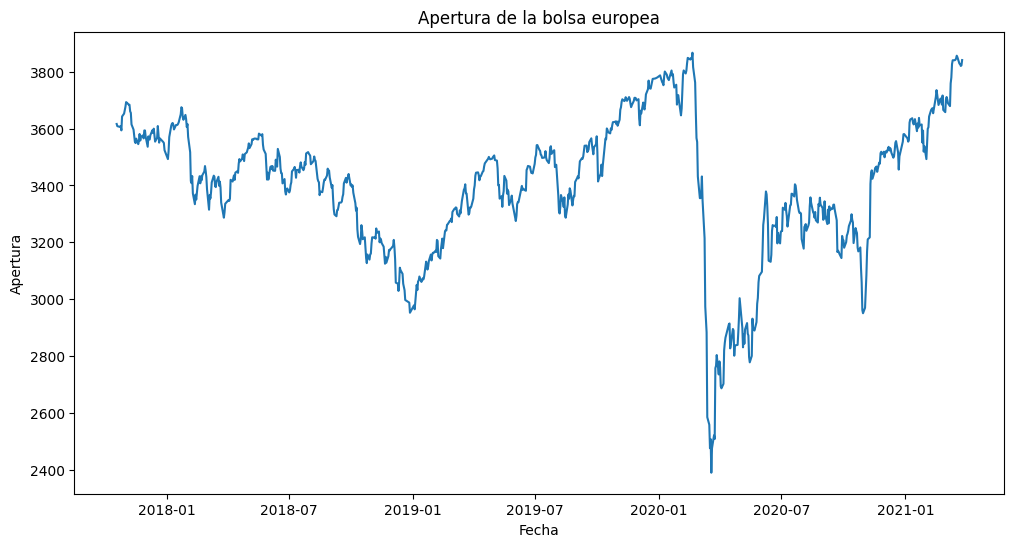

In [8]:
euro_open = euro[['Open']].copy() # seleccionamos la columna de apertura

# # reseteamos el índice
# euro_open.reset_index(inplace=True)

# # normalizamos los datos para que estén entre 0 y 1
# min_max_scaler = preprocessing.MinMaxScaler()
# euro_open['Open'] = min_max_scaler.fit_transform(euro_open['Open'].values.reshape(-1,1))

# Visualización de los datos
# =====================================================================
display(euro_open) # versión tabular

plt.figure(figsize=(12, 6)) # versión gráfica
plt.plot(euro_open['Open'])
plt.title('Apertura de la bolsa europea'), plt.xlabel('Fecha'), plt.ylabel('Apertura')
plt.savefig('../data/img/euro_open.png')
plt.show()

## 2. Análisis del DataFrame

### 2.1 Descomposición de la serie temporal

1. **Descomposición Aditiva**:
   - Los datos originales se descomponen en componentes aditivos, que incluyen tendencia, estacionalidad y residuos.
   - Los residuos del modelo aditivo muestran patrones que se suman de manera constante. Si estos residuos aumentan con el tiempo, esto podría indicar una tendencia creciente en la variabilidad de los datos.

2. **Descomposición Multiplicativa**:
   - Los datos originales se descomponen en componentes multiplicativos, que también incluyen tendencia, estacionalidad y residuos.
   - Elmodelo multiplicativo, los residuos son más constantes, y cualquier patrón de aumento se vería como una variabilidad proporcional. Un aumento constante en los residuos podría sugerir un aumento constante en la variabilidad relativa a la tendencia y la estacionalidad.

**Conclusión:**
- En la serie temporal los residuos aumentan de manera aditiva, mientras que en el enfoque multiplicativo los residuos se mantienen constantes, se podría concluir que la serie es más probablemente multiplicativa. Sin embargo, es importante realizar pruebas y validar el modelo para confirmar la elección del enfoque.

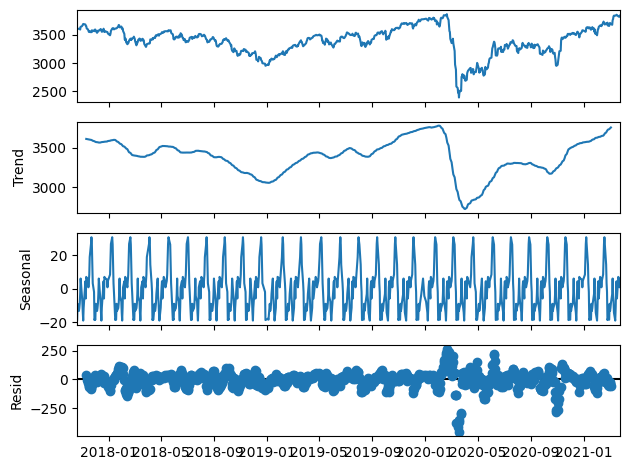

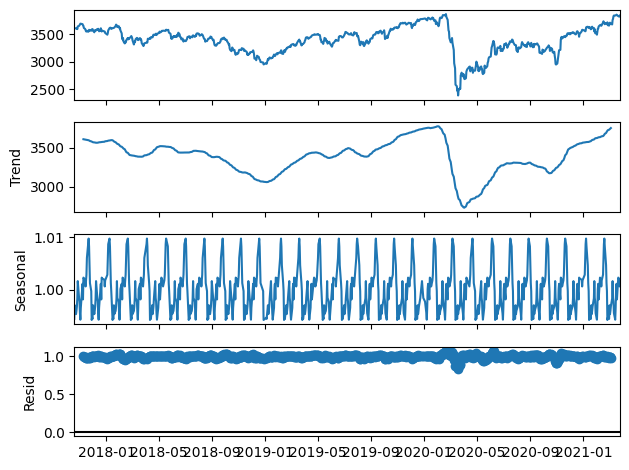

In [9]:
# Descomposición de la serie temporal
# =====================================================================

# Aditiva
result = seasonal_decompose(euro_open, model='additive', period = 30)
result.plot()
plt.show()

# Multiplicativa
result = seasonal_decompose(euro_open, model='multiplicative', period = 30)
result.plot()
plt.show()

### 2.2 Prueba de Dickey-Fuller

Como podemos observar, tras la prueba de dickey-fuller, la serie no se puede decir que es estacionaria. Esto lo podemos deducir del valor del estadístico de prueba (ADF estadístico) y el p-valor junto con la comparación de estos valores con los valores críticos. En este caso, el valor del estadístico de prueba es positivo (0.8153688792060498) y mayor que los valores críticos en diferentes niveles de significación (1%, 5%, 10%). Además, el valor p es alto (0.991880243437641), lo que indica que no podemos rechazar la hipótesis nula de que la serie no es estacionaria.

En resumen, la serie temporal no es estacionaria según los resultados de la prueba de Dickey-Fuller.

In [10]:
# Prueba de dickey-fuller
# =====================================================================
sts.adfuller(euro_open.Open) # p-value > 0.05, no se puede rechazar la hipótesis nula de que la serie temporal no es estacionaria

(-2.8108104298808287,
 0.05674609044132568,
 9,
 850,
 {'1%': -3.438066656679015,
  '5%': -2.8649462783472424,
  '10%': -2.5685837702422147},
 8373.592279278542)

Debido a la no estacionalidad de los valores de la serie, probamos a hacer su integración para representar la serie de una manera de variación porcentual con respecto a los días anteriores, lo cual puede dar un análisis más completo y para ver si podemos conseguir por lo menos que esta parte sea estacionaria para poder hacer un mejor estudio de la serie, pues la estacionalidad de una serie (media y desviación típica constantes) hará que podamos hacer un mejor análisis de esta, pues existirá una relación directa (autocorrelación, dependencia) entre los elementos futuros de la serie con los elementos pasados, además de que los errores son prácticamente cte. y, por tanto, previsibles.

La prueba de Dickey-Fuller con los retornos de la serie, los resultados de la prueba de Dickey-Fuller sugieren que es estacionaria, ya que el p valor es menor que 0.05 y el estadístico de prueba es negativo y menor que los valores críticos en el nivel de significación del 5% (aunque mayor que el 1%).

In [11]:
# Calculamos los retornos del dataset y hacemos también la prueba de dickey-fuller
# =====================================================================
euro_open['Returns'] = euro_open.Open.pct_change(1).mul(100) # returns in percentage (variación porcentual con respecto al mes anterior)
sts.adfuller(euro_open.Returns[1:]) # p-value < 0.05, se rechaza la hipótesis nula de que la serie temporal no es estacionaria

(-9.516698328996116,
 3.143184515152134e-16,
 8,
 850,
 {'1%': -3.438066656679015,
  '5%': -2.8649462783472424,
  '10%': -2.5685837702422147},
 2585.300697402814)

In [12]:
# Calculamos los retornos del dataset y hacemos también la prueba de dickey-fuller
# =====================================================================
euro_open['Returns_Returns'] = euro_open.Returns.pct_change(1).mul(100) # returns in percentage (variación porcentual con respecto al mes anterior)
sts.adfuller(euro_open.Returns_Returns[2:]) # p-value < 0.05, se rechaza la hipótesis nula de que la serie temporal no es estacionaria

(-29.212236659369204,
 0.0,
 0,
 857,
 {'1%': -3.438003436504483,
  '5%': -2.864918407242872,
  '10%': -2.5685689238190808},
 16423.32942077045)

### 2.3 Análisis de la autocorrelación

En ambos casos, optaremos por seleccionar un rezago temporal (lag) de 24 unidades, dado que al abordar el número de pasajeros por mes, la consideración de un período de análisis de 2 años (24 meses) puede conferir mayor representatividad a la serie temporal.

- Mediante el análisis de autocorrelación de la serie de pasajeros, se aprecia que, a nivel global (ACF), la influencia preponderante en el número de pasajeros de un mes específico proviene del mes inmediatamente anterior. Aunque se puede observar un patrón sugerente de 12 meses, reflejado en la evolución de la autocorrelación a lo largo de los 24 lags, indicando que la serie podría estar influenciada significativamente por los últimos 12 meses. Por otro lado, en el análisis a nivel parcial (PACF), revela que la serie se ve afectada tanto por el mes anterior como por el mes del año anterior, es decir, el mes 12.

  Por ejemplo, el ACF y el PACF indican que el número de pasajeros en un mes determinado se encuentra influido tanto por el mes precedente como por el mismo mes del año anterior (mes 12).

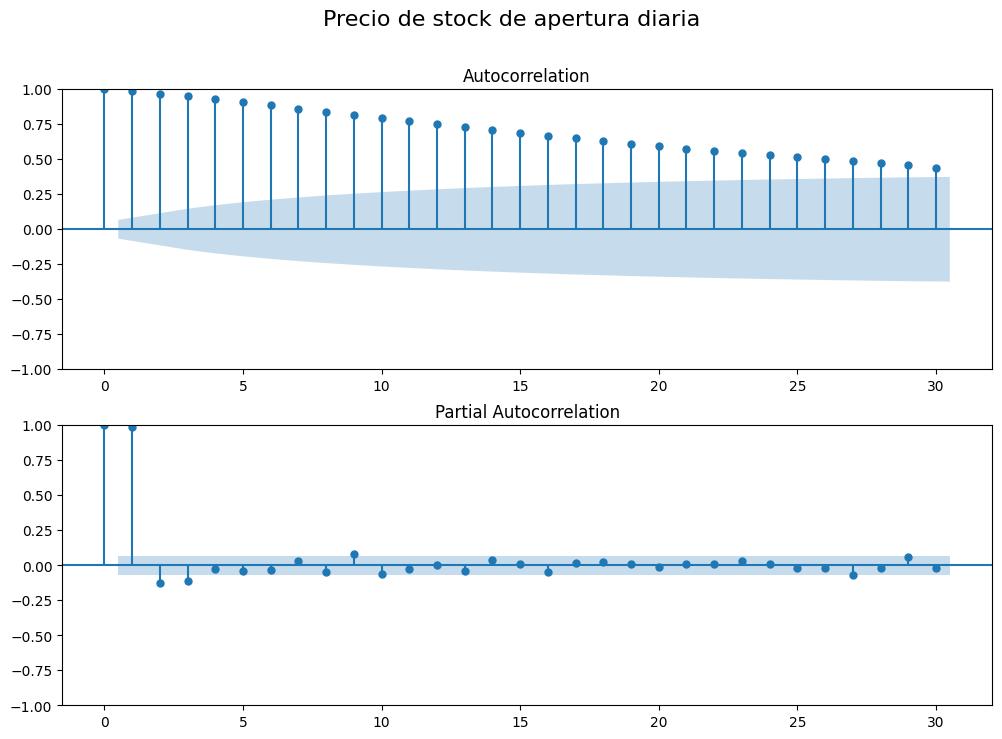

In [13]:
# Análisis de la autocorrelación de los pasajeros mensuales
# =====================================================================
def plot_acf_pacf(df, lags, title):
    fig, ax = plt.subplots(2,1,figsize=(12,8))
    plt.suptitle(title, fontsize=16)
    sgt.plot_acf(df, lags = lags, ax=ax[0]) # autocorrelación
    sgt.plot_pacf(df, lags = lags, ax=ax[1]) # autocorrelación parcial
    plt.show()


plot_acf_pacf(euro_open.Open,lags=30, title='Precio de stock de apertura diaria')

- El análisis de autocorrelación para los retornos de los pasajeros muestra algo similar al de los pasajeros, pero más marcado, indicando que la serie se ve influencia por los valores de los 12 y 24 últimos meses y a nivel parcial solo cada 12 meses.

  Al realizar el análisis de autocorrelación de los retornos de los pasajeros, se observa una similitud con la serie de pasajeros, aunque con una marcada intensificación. A nivel global (ACF), se aprecia una relación significativa con los últimos 12 y 24 meses, indicando una influencia persistente a lo largo de estos períodos. En el análisis a nivel parcial (PACF), se revela que la serie de retornos se ve afectada principalmente cada 12 meses.

  Este patrón refleja una dependencia significativa en los últimos dos años, señalando que los retornos de un mes dado se ven afectados por los valores de los dos años anteriores y a nivel individual por el mes del año anterior. La presencia de correlaciones persistentes cada 12 meses en el análisis a nivel parcial refuerza la idea de que la serie de retornos exhibe una estructura estacional anual.

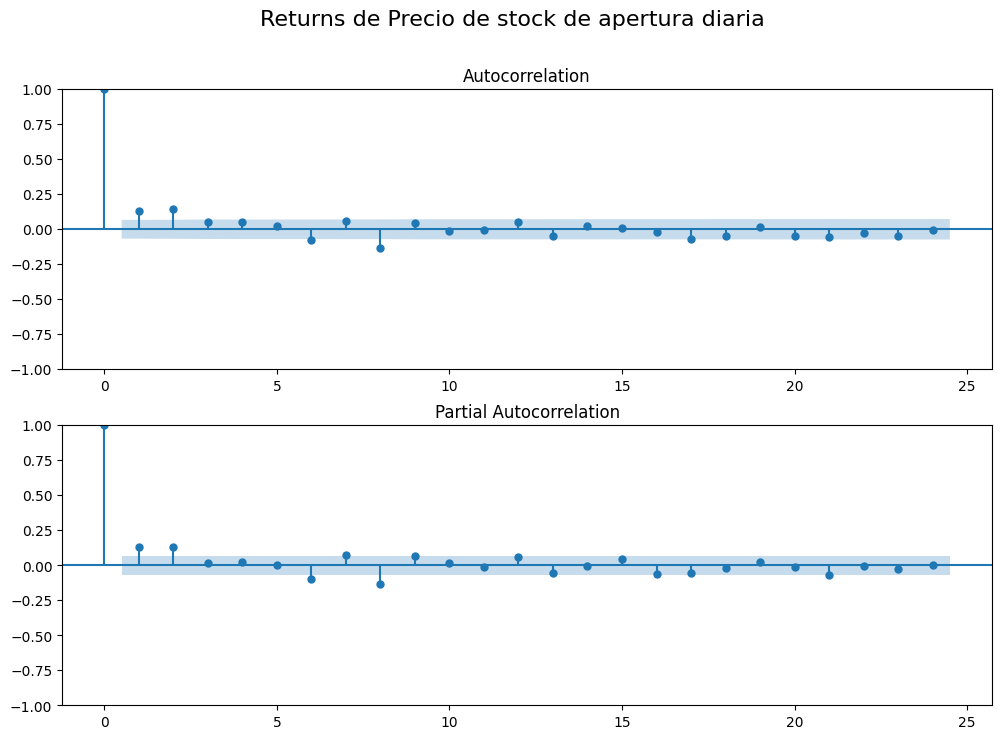

In [14]:
# Análisis de la autocorrelación del retorno pasajeros mensuales
# =====================================================================
plot_acf_pacf(euro_open.Returns[1:],lags=24, title='Returns de Precio de stock de apertura diaria')

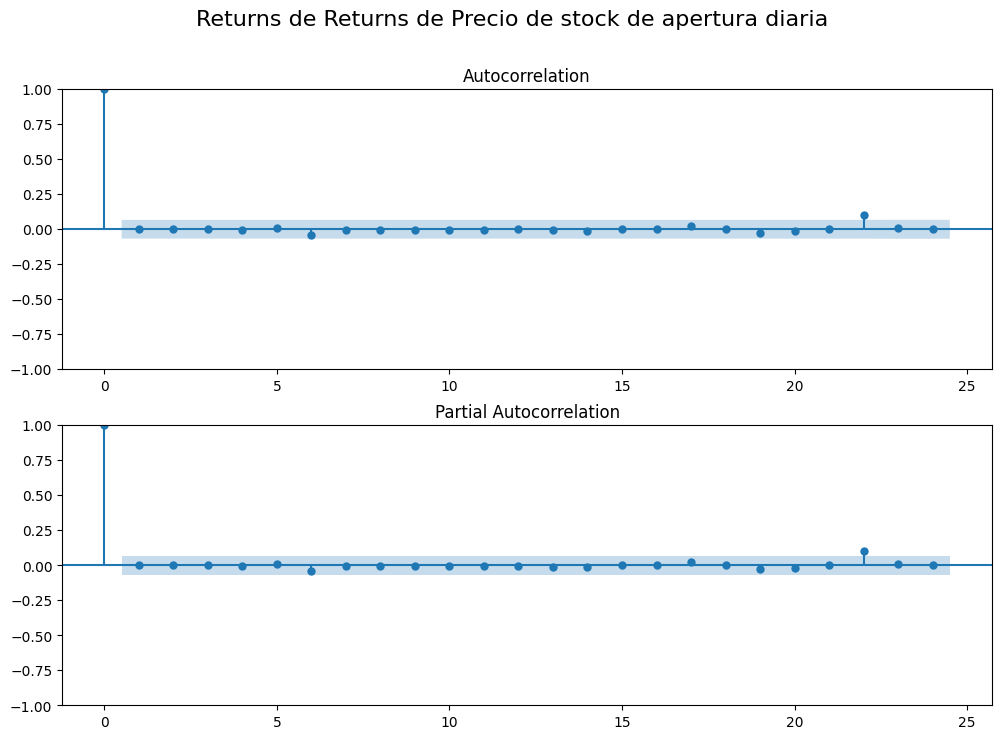

In [15]:
# Análisis de la autocorrelación del retorno pasajeros mensuales
# =====================================================================
plot_acf_pacf(euro_open.Returns_Returns[2:],lags=24, title='Returns de Returns de Precio de stock de apertura diaria')

## 3. Métodos de Predicción

In [16]:
# División de los datos en train y test
# =====================================================================
size = len(euro_open) - 10
wd_train, wd_test = euro_open.iloc[:size], euro_open.iloc[size:]

### 3.0 AR, MA, ARMA

Antes de pasar a los modelos de la práctica, vamos a realizar un análisis de los modelos AR, MA y ARMA para poder usar estos modelos como base para los modelos ARIMA, SARIMA y SARIMAX y elegir sus hiperparámetros. Para ello, usaremos la primera serie estacionaria (retornos de la serie de pasajeros).

#### 3.0.1 AR

- El modelo AR, se trata de un modelo autorregresivo, es decir, un modelo que predice el valor futuro de una variable en función de sus valores pasados. En este caso, el modelo AR se basa en la regresión lineal de la variable dependiente (y) con respecto a sus valores pasados (y(t-1), y(t-2), ...), es decir, la variable dependiente se regresa a sí misma.

In [17]:
# AR
# =====================================================================
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tsa import ar_model

# AIC
ARfitAIC = ar_model.ar_select_order(wd_train.Returns[1:],17, ic="aic", glob=True)
orden=ARfitAIC.ar_lags # orden del modelo
print(f'Lag: {orden}')

Lag: [1, 2, 4, 6, 7, 8, 9, 12, 13, 15, 16, 17]


In [18]:
from sklearn.metrics import mean_squared_error
import pandas as pd

testGeneral = [1, 2, 4, 6, 7, 8, 9, 12, 13, 15, 16, 17] # elegimos los lags que nos interesan

ModelArima = {}

llf_list = []
aic_list = []
bic_list = []
error_list = []

for x in testGeneral:
  model_ar = ARIMA(wd_train.Returns[1:], order=(x,0,0))
  results_ar = model_ar.fit()
  results_arfore = results_ar.forecast(steps=len(wd_test.Returns))
  ModelArima["AR("+str(x)+")"] = results_arfore

  error = mean_squared_error(wd_test.Returns, results_arfore)

  llf_list.append(results_ar.llf)
  aic_list.append(results_ar.aic)
  bic_list.append(results_ar.bic)
  error_list.append(error)

#########LO HE HECHO CON PLOTS PUES SI NO ME SALIAN LOS VALORES ENTREMIAS DE LOS AVISOS DEL OUTPUT DE ESTA CELDA Y NO SE VEIA MUY CLATO PARA HACER UN ANALISIS DE LOS RESULTADOS#########

# LLF -> Log Likelihood Function, represents the log of the likelihood function so the higher the LLF the better the model is
print("LLF")
for i in range(len(testGeneral)):
  print(f'AR({testGeneral[i]}): {llf_list[i]}')
  
print()

# AIC -> represents the tradeoff between the goodness of fit of the model and the simplicity of the model so the lowest AIC is chosen the better the model is
print("AIC")
for i in range(len(testGeneral)):
  print(f'AR({testGeneral[i]}): {aic_list[i]}')
  
print()

# BIC -> is a criterion for model selection among a finite set of models; the model with the lowest BIC is preferred
print("BIC")
for i in range(len(testGeneral)):
  print(f'AR({testGeneral[i]}): {bic_list[i]}')
  
print()

# Error -> the lower the error the better the model is
print("Error")
for i in range(len(testGeneral)):
  print(f'AR({testGeneral[i]}): {error_list[i]}')
  
print()

LLF
AR(1): -1321.201038704897
AR(2): -1313.7278870750922
AR(4): -1313.2884362635832
AR(6): -1309.2189389783437
AR(7): -1306.791272127102
AR(8): -1298.8475086043698
AR(9): -1296.6887655766695
AR(12): -1295.0111060954755
AR(13): -1293.5949146140356
AR(15): -1292.6459162387641
AR(16): -1290.738261488983
AR(17): -1289.6535823810782

AIC
AR(1): 2648.402077409794
AR(2): 2635.4557741501844
AR(4): 2638.5768725271664
AR(6): 2634.4378779566873
AR(7): 2631.582544254204
AR(8): 2617.6950172087395
AR(9): 2615.377531153339
AR(12): 2618.022212190951
AR(13): 2617.189829228071
AR(15): 2619.2918324775283
AR(16): 2617.476522977966
AR(17): 2617.3071647621564

BIC
AR(1): 2662.634254968728
AR(2): 2654.43201089543
AR(4): 2667.0412276450343
AR(6): 2672.390351447178
AR(7): 2674.2790769310063
AR(8): 2665.1356090718527
AR(9): 2667.562182202764
AR(12): 2684.4390407993096
AR(13): 2688.3507170227413
AR(15): 2699.9408386448213
AR(16): 2702.8695883315704
AR(17): 2707.444289302072

Error
AR(1): 0.0738445424652128
AR(2)

- Basándonos en estos valores, podemos ver que los mejores modelos son los de AR(1), AR(2) y AR(8) pues son los que tienen menor error, AIC, BIC y mayor LLF. De entre estos modelos, el que tiene menor error es el AR(13), pero antes de elegir un único valor, veamos un plot para decidirnos.

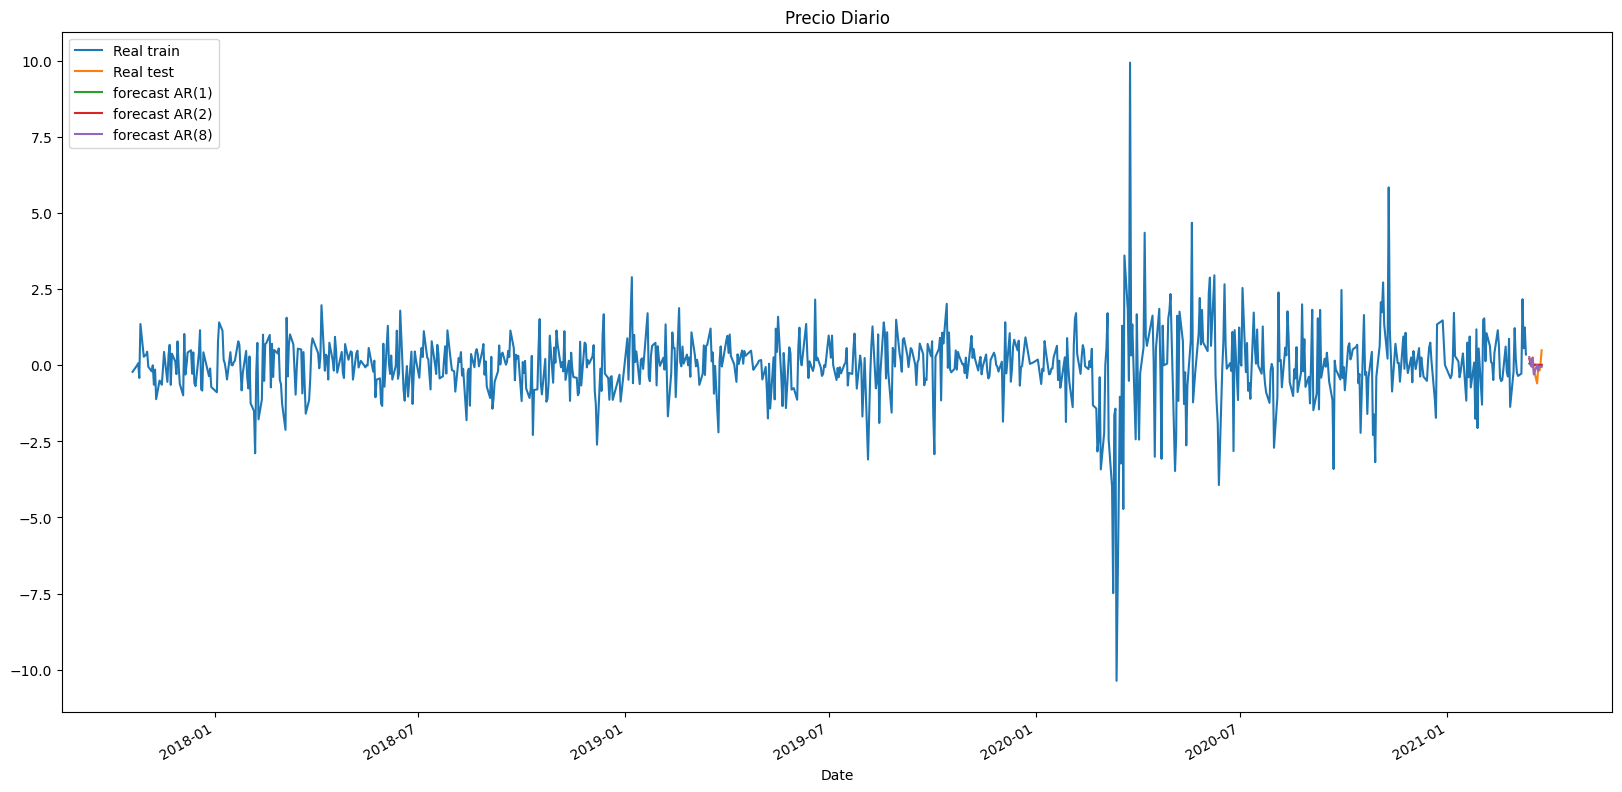

In [19]:
testGeneral = [1,2,8] # elegimos los lags que nos interesan con menor LLF, AIC, BIC y error

wd_train.Returns.plot(figsize=(20,10), title = "Precio Diario", label='Real train') # hacemos el plot de los datos de entrenamiento ajustado para que se vea mejor
wd_test.Returns[1:].plot(label='Real test')

for x in testGeneral:
   ModelArima["AR("+str(x)+")"].index=wd_test.Returns.index
   ModelArima["AR("+str(x)+")"].plot(label='forecast AR('+str(x)+")")
plt.legend(loc="upper left")
plt.show()

- Elección del modelo AR(1) para la predicción de la serie de pasajeros.

  - **AR(1)**: El modelo AR(1) tiene el menor error de entre todos tiniendo el resto de valores (LLF, AIC y BIC) muy similares a los del resto de modelos, por lo que elegiremos este modelo para predecir los valores de la serie. Y además como podemos observar es el que más se acercaba a los valores reales de la serie manreninedo un buen trade-off entre el error y la complejidad del modelo.

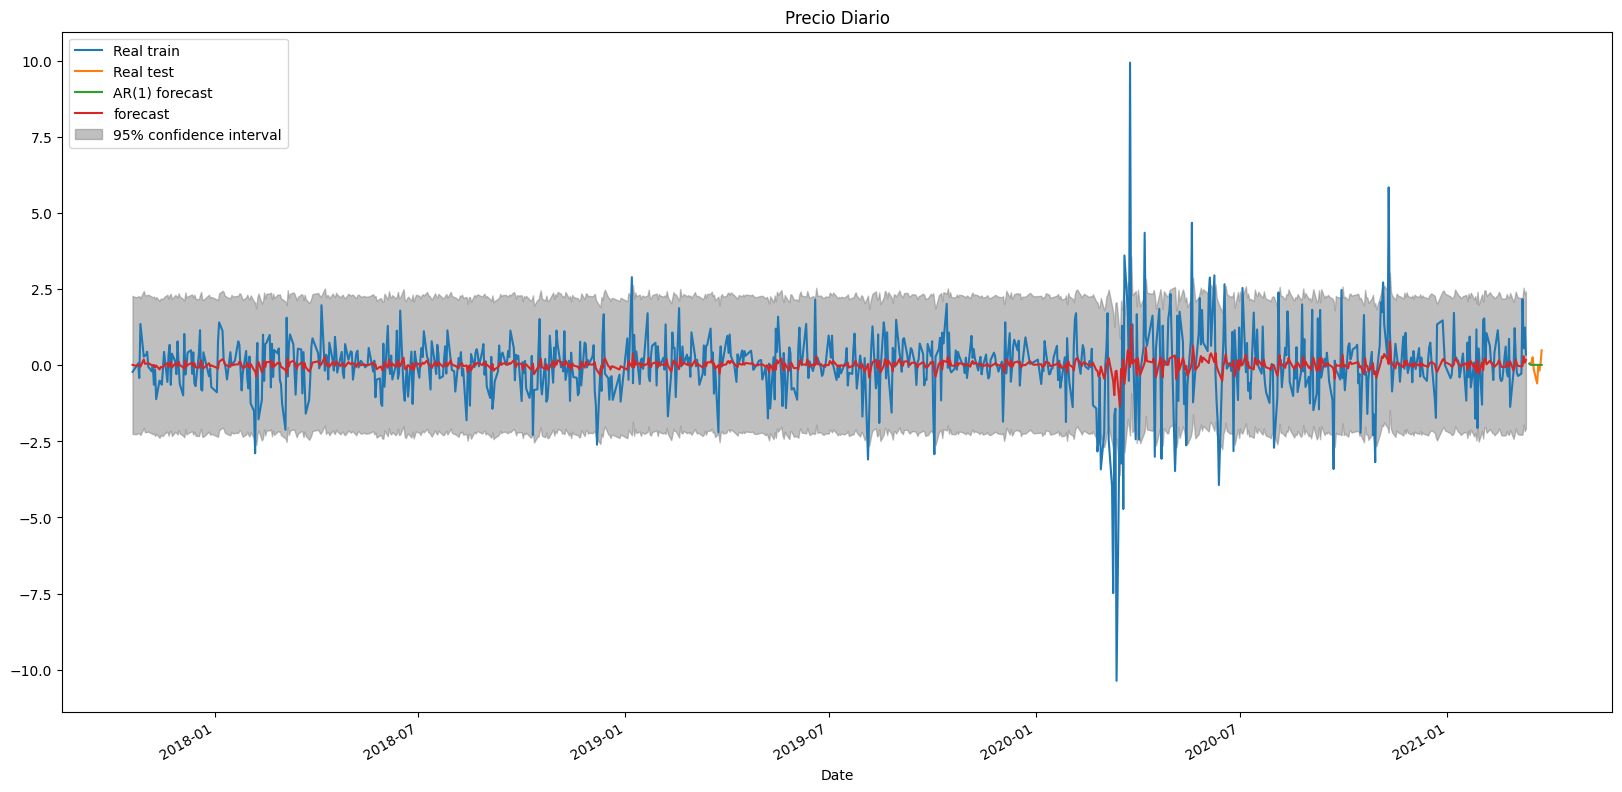

In [20]:
# AR(1) aunque 2 tmb estaba bien
# =====================================================================

# Plot adjusts
fig, ax = plt.subplots()
ax = wd_train.Returns[1:].plot(ax=ax,figsize=(20,10), title = "Precio Diario", label='Real train')
ax = wd_test.Returns[1:].plot(ax=ax,figsize=(20,10), title = "Precio Diario", label='Real test')

# AR(13)
model_ar = ARIMA(wd_train.Returns[1:], order=(1,0,0)) # elegimos el modelo con menor LLF, AIC, BIC y error, en este caso AR(13)
results_ar = model_ar.fit()
results_arfore = results_ar.forecast(steps=10)
results_arfore.index=wd_test.Returns.index

# Plot
ax = results_arfore.plot(ax=ax, label='AR(1) forecast')
plot_predict(results_ar, dynamic=False,ax=ax)
plt.legend(loc="upper left")
plt.show()

- Como podemos observar, el modelo AR(1) se ajusta bastante bien a los valores reales de la serie, pues el error es bastante bajo y el modelo se ajusta bastante bien a los valores reales de la serie. Por lo que tanto teóricamente c0mo visualmente, podemos decir que el modelo AR(1) es un buen modelo para predecir los valores de la serie.

In [21]:
# Latent Likelihood Ratio
from scipy.stats.distributions import chi2
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

In [22]:
# MA
# =====================================================================
from sklearn.metrics import mean_squared_error

ModelArima=dict()
results_maprey=None

llf_list = []
aic_list = []
bic_list = []
error_list = []

testGeneral = range(25)

for x in testGeneral:
  model_ma = ARIMA(wd_train.Returns[1:], order=(0,0,x))
  results_ma = model_ma.fit()
  results_mafore = results_ma.forecast(steps=len(wd_test.Returns))
  ModelArima["MA("+str(x)+")"] = results_mafore

  error = None
  if results_maprey is not None:
    error = str(LLR_test(results_maprey, results_ma))

  results_maprey=results_ma
  
  llf_list.append(results_ma.llf)
  aic_list.append(results_ma.aic)
  bic_list.append(results_ma.bic)
  error_list.append(error)

#########LO HE HECHO CON PLOTS PUES SI NO ME SALIAN LOS VALORES ENTREMIAS DE LOS AVISOS DEL OUTPUT DE ESTA CELDA Y NO SE VEIA MUY CLATO PARA HACER UN ANALISIS DE LOS RESULTADOS#########

# LLF -> Log Likelihood Function, represents the log of the likelihood function so the higher the LLF the better the model is
print("LLF")
for i in range(len(testGeneral)):
  print(f'AR({testGeneral[i]}): {llf_list[i]}')
  
print()

# AIC -> represents the tradeoff between the goodness of fit of the model and the simplicity of the model so the lowest AIC is chosen the better the model is
print("AIC")
for i in range(len(testGeneral)):
  print(f'AR({testGeneral[i]}): {aic_list[i]}')
  
print()

# BIC -> is a criterion for model selection among a finite set of models; the model with the lowest BIC is preferred
print("BIC")
for i in range(len(testGeneral)):
  print(f'AR({testGeneral[i]}): {bic_list[i]}')
  
print()

# LLR test p-vaue -> the lower the error the better the model is
print("LLR test p-vaue")
for i in range(len(testGeneral)):
  print(f'AR({testGeneral[i]}): {error_list[i]}')

LLF
AR(0): -1328.72959725527
AR(1): -1322.8160331705317
AR(2): -1315.1454271473413
AR(3): -1314.5397146485655
AR(4): -1312.1945065770853
AR(5): -1312.0848519518033
AR(6): -1310.6299879647486
AR(7): -1307.7673458820652
AR(8): -1296.7370408829386
AR(9): -1296.0675989579547
AR(10): -1295.6764271239558
AR(11): -1295.6646441513788
AR(12): -1294.7634176477247
AR(13): -1293.9097152926054
AR(14): -1293.7002657999028
AR(15): -1293.686892905661
AR(16): -1293.6085105415225
AR(17): -1290.7798392520885
AR(18): -1290.227924784714
AR(19): -1289.246184550057
AR(20): -1288.7269060829933
AR(21): -1288.6182126736044
AR(22): -1287.9895244315999
AR(23): -1287.4434553672922
AR(24): -1286.4160243651027

AIC
AR(0): 2661.45919451054
AR(1): 2651.6320663410634
AR(2): 2638.2908542946825
AR(3): 2639.079429297131
AR(4): 2636.3890131541707
AR(5): 2638.1697039036067
AR(6): 2637.259975929497
AR(7): 2633.5346917641305
AR(8): 2613.474081765877
AR(9): 2614.1351979159094
AR(10): 2615.3528542479116
AR(11): 2617.32928830275

- Basándonos en estos valores, podemos ver que los mejores modelos son los de MA(1-7) pues son los que tienen mejor equilibrio de menor error, AIC, BIC y mayor LLF.

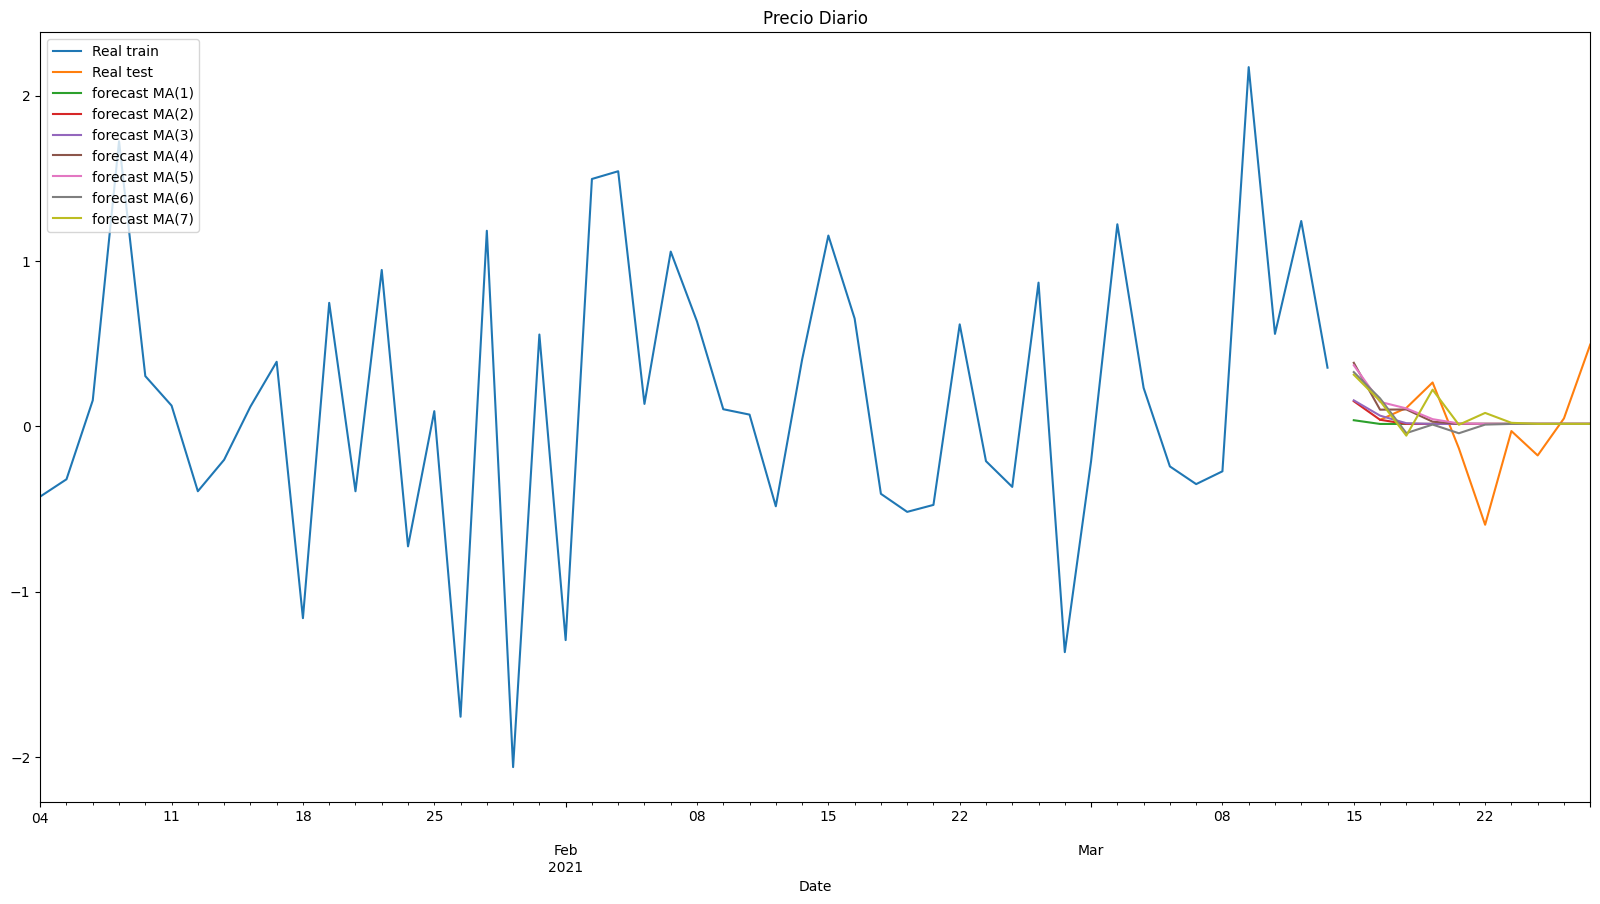

In [23]:
testGeneral = [1,2,3,4,5,6,7] # elegimos los lags que nos interesan con menor LLF, AIC, BIC y error

wd_train.Returns[800:].plot(figsize=(20,10), title = "Precio Diario", label='Real train')
wd_test.Returns[1:].plot(label='Real test')
for x in testGeneral:
   ModelArima["MA("+str(x)+")"].index=wd_test.Returns.index
   ModelArima["MA("+str(x)+")"].plot(label='forecast MA('+str(x)+")")
plt.legend(loc="upper left")
plt.show()

- Tras ver los resultados, vemos que el modelo MA(24) es el que visualmente se ve mejor y además tiene un LLF alto, menor error, AIC y BIC con respecto a los otros MA, por lo que elegiremos este modelo para predecir los valores de la serie.

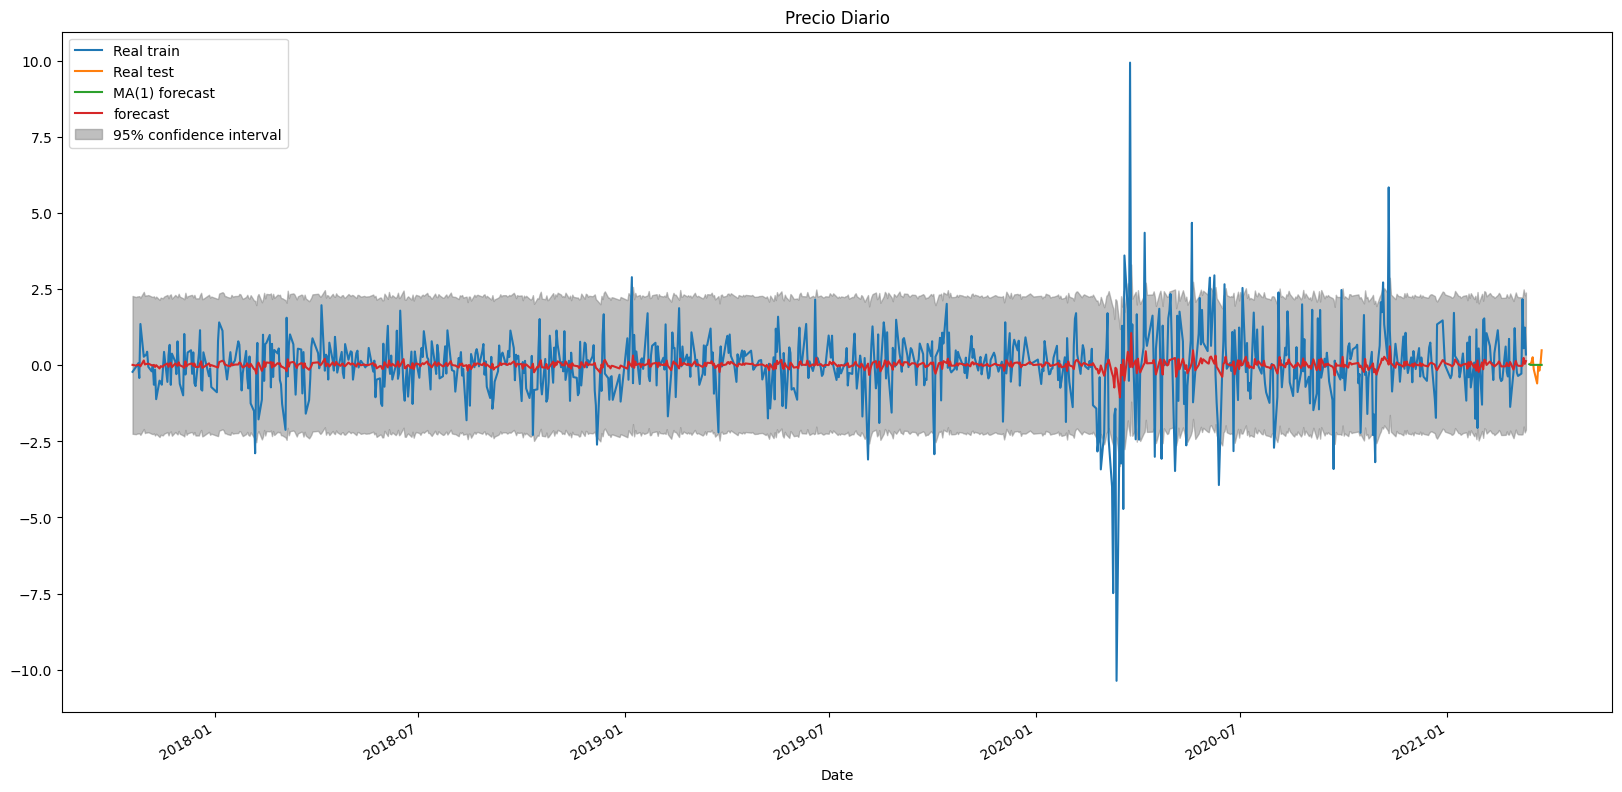

In [24]:
# MA(24)
# =====================================================================

# Plot adjusts
fig, ax = plt.subplots()
ax = wd_train.Returns[1:].plot(ax=ax,figsize=(20,10), title = "Precio Diario", label='Real train')
ax = wd_test.Returns[1:].plot(ax=ax,figsize=(20,10), title = "Precio Diario", label='Real test')

model_ma = ARIMA(wd_train.Returns[1:], order=(0,0,1)) # elegimos el modelo con menor LLF, AIC, BIC y error, en este caso MA(22)
results_ma = model_ma.fit()
results_mafore = results_ma.forecast(steps=10)
results_mafore.index=wd_test.Returns.index

# Plot
ax = results_mafore.plot(ax=ax,label='MA(1) forecast')
plot_predict(results_ma, dynamic=False,ax=ax)
plt.legend(loc="upper left")
plt.show()

- Vemos que los resultados son bastante buenos, pues el LLF es alto, el error, AIC y BIC son bastante bajos con respecto a los otros MA, por lo que el modelo se ajusta bastante bien a los valores reales de la serie.

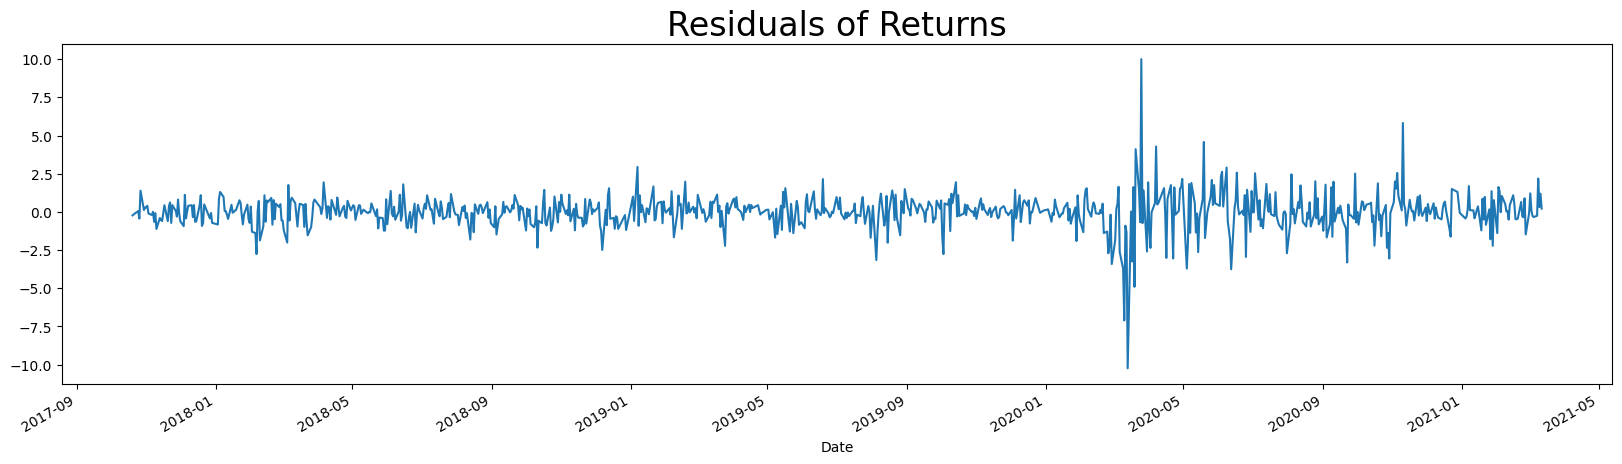

In [25]:
results_ma.resid
results_ma.resid.plot(figsize = (20,5))
plt.title("Residuals of Returns", size = 24)
plt.show()

In [26]:
sts.adfuller(results_ma.resid)[1]

2.010099117732806e-16

#### 3.0.3 ARMA

- El modelo ARMA, se trata de un modelo autorregresivo de media móvil, es decir, un modelo que predice el valor futuro de una variable en función de sus valores pasados y de los errores pasados. En este caso, el modelo ARMA se basa en la regresión lineal de la variable dependiente (y) con respecto a sus valores pasados (y(t-1), y(t-2), ...) y de sus errores pasados (e(t-1), e(t-2), ...), es decir, la variable dependiente se regresa a sí misma y a sus errores pasados.

Para los valores de ARMA, elegimos los valores obtenidos en los modelos AR y MA, es decir, AR(13) y MA(24), pues son los que mejores resultados han dado en sus respectivos modelos.

In [27]:
# ARMA
# =====================================================================
model_arma = ARIMA(wd_train.Returns[1:], order=(1,0,1)) # elegimos el modelo con mayor LLF y emnor, AIC, BIC y error, en los modelos AR y MA ->(13,24)
results_arma = model_arma.fit() # ajustamos el modelo
sts.adfuller(results_arma.resid) # p-value < 0.05, se rechaza la hipótesis nula de que la serie temporal no es estacionaria

(-10.285258053616339,
 3.6892432724724205e-18,
 8,
 840,
 {'1%': -3.4381588046529123,
  '5%': -2.8649869014550267,
  '10%': -2.5686054095804987},
 2563.618374459873)

- Puesto que el p-valor es menor que 0.05, podemos decir que el modelo ARMA(13,24) es una serie estacionaria. Además, el LLF es alto, el error, AIC y BIC son bastante bajos con respecto a los otros ARMA, por lo que el modelo se ajusta bastante bien a los valores reales de la serie.

- Ahora calculamos los residuos del modelo ARMA(13,24)

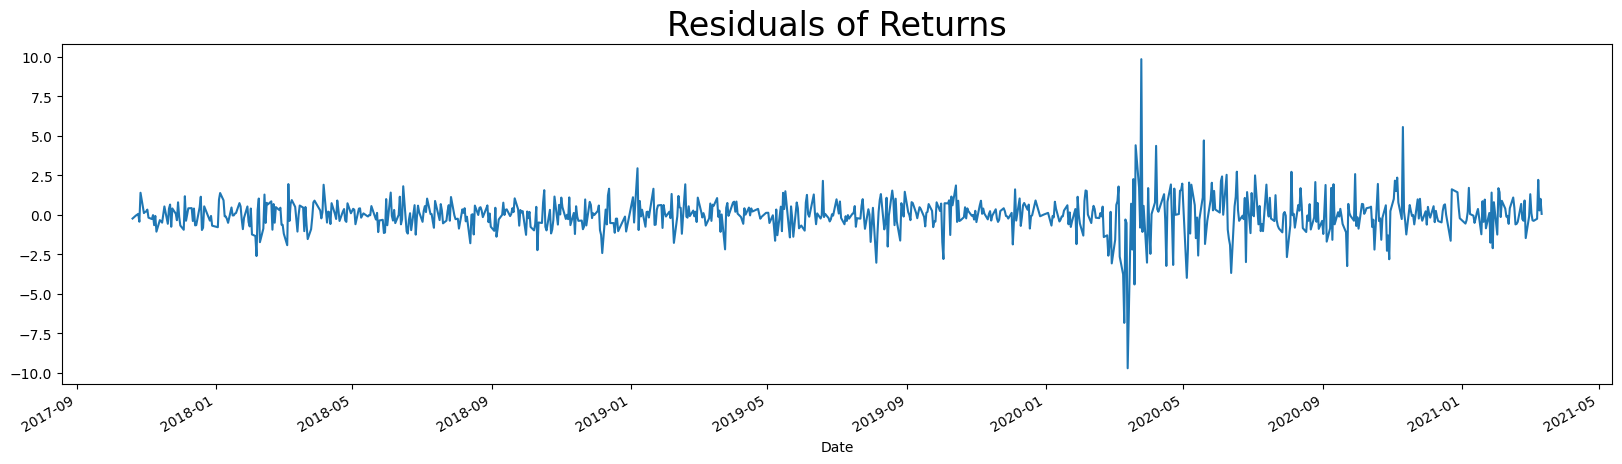

In [28]:
results_arma.resid.plot(figsize = (20,5))
plt.title("Residuals of Returns", size = 24)
plt.show()

- Ahora, entrenamos el modelo ARMA(1,1) y sacamos los residuos para ver si son estacionarios con el test de Dickey-Fuller.

  - Como podemos observar, el p-valor es menor que 0.05, por lo que podemos decir que los residuos son estacionarios.

In [29]:
model_arma_1_1 = ARIMA(wd_train.Returns[1:], order=(1,0,1))
results_arma_1_1 = model_arma_1_1.fit()
sts.adfuller(results_arma_1_1.resid)

(-10.285258053616339,
 3.6892432724724205e-18,
 8,
 840,
 {'1%': -3.4381588046529123,
  '5%': -2.8649869014550267,
  '10%': -2.5686054095804987},
 2563.618374459873)

- Finalmente, visualizamos un predict plot del modelo ARMA(13,24) para ver si se ajusta bien a los valores reales de la serie y lo comparamos con los modelos AR(13) y MA(24) para ver cual funciona mejor. Como podemos observar, el modelo ARMA(13,24) se ajusta bastante bien a los valores reales de la serie. Sin embargo, el modelo AR(13) se ajusta mejor a los valores reales de la serie que el ARMA(13,24) y el MA(24) se ajusta peor a los valores reales de la serie que el ARMA(13,24).

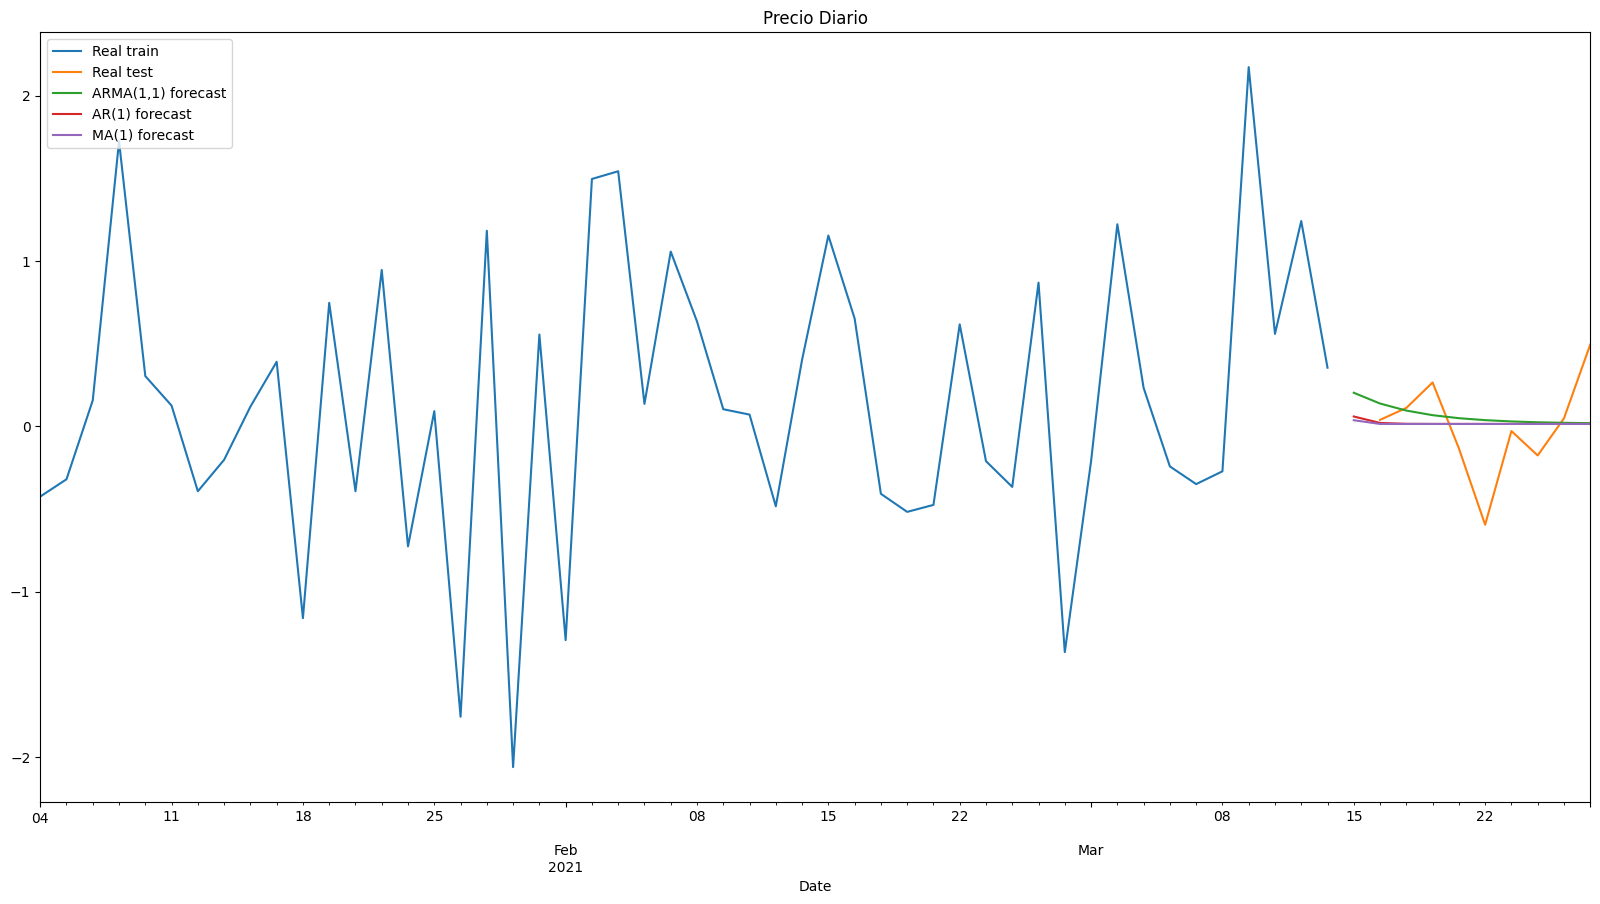

In [30]:
fig, ax = plt.subplots()
ax = wd_train.Returns[800:].plot(ax=ax,figsize=(20,10), title = "Precio Diario", label='Real train')
ax = wd_test.Returns[1:].plot(ax=ax,figsize=(20,10), title = "Precio Diario", label='Real test')

model_arma = ARIMA(wd_train.Returns[1:], order=(1,0,1))
results_arma = model_arma.fit()
results_armafore = results_arma.forecast(steps=10)
results_armafore.index=wd_test.Returns.index

ax = results_armafore.plot(ax=ax,label='ARMA(1,1) forecast')
ax = results_arfore.plot(ax=ax, label='AR(1) forecast')
ax = results_mafore.plot(ax=ax,label='MA(1) forecast')

#plot_predict(results_ma, dynamic=False,ax=ax)
plt.legend(loc="upper left")
plt.show()

### 3.1 ARIMA

Como hemos visto el ARMA(13,24) sobre los retornos se ajusta bastante bien a los datos y la predicción de estos. Puesto hemos tenido que hacer una diferenciación sobre la serie para poder hacerla estacionaria, vamos a probar a hacer un modelo ARIMA para predecir los valores de la serie de pasajeros y comparar los resultados con el ARMA(13,24) sobre la serie original.

Para los hiperparámetros del modelo ARIMA, vamos a usar los mismos que en el modelo ARMA(13,24), es decir, AR(13) y MA(24) y como hemos tenido que hacer una diferenciación sobre la serie, usaremos una diferenciación de orden 1.

In [31]:
# ARIMA
# =====================================================================
model_arima = ARIMA(wd_train.Open, order=(1,1,1))
results_arima = model_arima.fit()
sts.adfuller(results_arima.resid)

(-11.241853748527417,
 1.7989140042246587e-20,
 8,
 841,
 {'1%': -3.4381494909387555,
  '5%': -2.864982795593248,
  '10%': -2.568603222439172},
 8288.076223415903)

- Como podemos observar, tras el test de Dickey-Fuller, la serie usando el modelo ARIMA es estacionaria, pues el p-valor es menor que 0.05 y el estadístico de prueba es menor que los valores críticos en los diferentes niveles de significación. Ahora, vamos a ver si podemos mejorar el modelo ARMA(13,24).

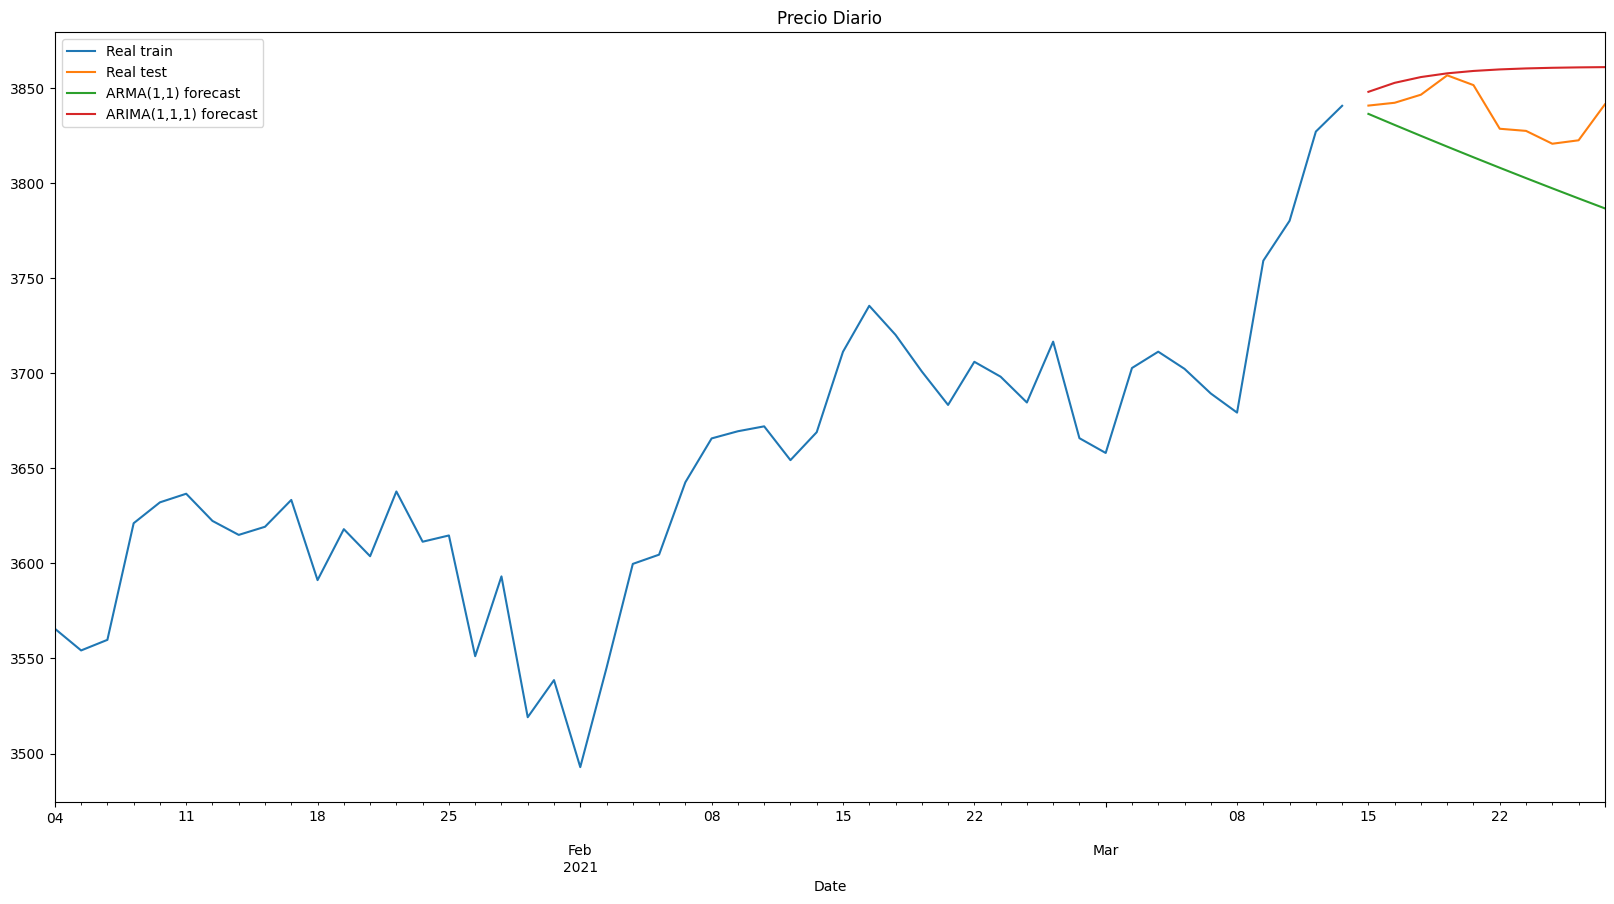

In [32]:
fig, ax = plt.subplots()
ax = wd_train.Open[800:].plot(ax=ax,figsize=(20,10), title = "Precio Diario", label='Real train')
ax = wd_test.Open.plot(ax=ax,figsize=(20,10), title = "Precio Diario", label='Real test')

# ARIMA (1,1,1)
model_arima = ARIMA(wd_train.Open, order=(1,1,1))
results_arima = model_arima.fit()
results_arimafore = results_arima.forecast(steps=10)
results_arimafore.index=wd_test.Open.index

# ARMA (1,1) -> ARIMA (1,0,1)
model_arma = ARIMA(wd_train.Open, order=(1,0,1))
results_arma = model_arma.fit()
results_armafore = results_arma.forecast(steps=10)
results_armafore.index=wd_test.Open.index

# Plot de los resultados
ax = results_armafore.plot(ax=ax,label='ARMA(1,1) forecast')
ax = results_arimafore.plot(ax=ax,label='ARIMA(1,1,1) forecast')
plt.legend(loc="upper left")
plt.show()

- Una vez entrenado el modelo ARIMA(13,1,24), vemos que el resultado que obtenemos es mejor que el ARMA(13,24) pues sigue más fielmente el comportamiento de los valores reales de la serie debido a como sigue esa tendencia ascendente de la serie.

### 3.2 SARIMA

Como hemos visto en el análisis de la autocorrelación, la serie integrada tiene una estacionalidad de 12 meses y de 24 meses. Lo cual tendremos que tener en cuenta a la hora de aplicar los hipermarámetros de SARIMA. Por ello, introduciremos dicha estacionalidad temporal conocida:

In [33]:
# SARIMA (1,1,2,12)
# =====================================================================
# order (p,d,q) -> (0,1,0)
# p(1) -> pues en el seasonal order tenemos P(1) y AR es AR(13) entonces queda p(1)
# d(1) -> pues diferenciamos una vez para hacer la serie estacionaria
# q(0)  -> pues en el seasonal order tenemos Q(2) y MA es MA(24) entonces queda q(0)
# seasonal order (P,D,Q,s) -> (1,1,2,12)
# P(1) -> pues AR se repite cada 12 meses (PACF)
# D(1) -> pues diferenciamos una vez para hacer la serie estacionaria y la componente estacionaria se repite con periodicidad.
# Q(2) -> pues MA se repite cada 12 meses y cada 12*2 meses (ACF)
# s(12) -> pues la serie es anualmente

modelSarima = SARIMAX(wd_train.Open, order=(1,1,1), seasonal_order=(1,1,2,5), enforce_invertibility=False) # s, P, D, Q -> (1,1,2,12)
resultsSarima = modelSarima.fit()
resultsSarima.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.08049D+00    |proj g|=  8.66770D-02

At iterate    5    f=  5.06483D+00    |proj g|=  1.18946D-02

At iterate   10    f=  5.06362D+00    |proj g|=  3.89264D-02

At iterate   15    f=  5.01157D+00    |proj g|=  1.44770D-01

At iterate   20    f=  4.99232D+00    |proj g|=  1.96313D-01

At iterate   25    f=  4.98739D+00    |proj g|=  7.21480D-02

At iterate   30    f=  4.98690D+00    |proj g|=  3.99712D-03

At iterate   35    f=  4.98679D+00    |proj g|=  2.73155D-01

At iterate   40    f=  4.98128D+00    |proj g|=  1.23543D+00

At iterate   45    f=  4.97774D+00    |proj g|=  6.58341D-01

At iterate   50    f=  4.97679D+00    |proj g|=  5.06104D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                   Open   No. Observations:                  850
Model:             SARIMAX(1, 1, 1)x(1, 1, [1, 2], 5)   Log Likelihood               -4230.268
Date:                                Mon, 22 Jan 2024   AIC                           8472.537
Time:                                        11:53:56   BIC                           8500.966
Sample:                                             0   HQIC                          8483.430
                                                - 850                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6491      0.075      8.703      0.000       0.503       0.795
ma.L1         -0.5015      0.086     -5.832      0.000      -0.670      -0.333
ar.S.L5        0.9161      0.177      5.184      0.000       0.570       1.262
ma.S.L5       -1.9789      0.443     -4.464      0.000      -2.848      -1.110
ma.S.L10       0.9774      0.445      2.196      0.028       0.105       1.849
sigma2      1211.6432    343.545      3.527      0.000     538.307    1884.979
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):              3113.49
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               4.22   Skew:                            -0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.08049D+00    |proj g|=  8.66770D-02

At iterate    5    f=  5.06483D+00    |proj g|=  1.18946D-02

At iterate   10    f=  5.06362D+00    |proj g|=  3.89264D-02


 This problem is unconstrained.



At iterate   15    f=  5.01157D+00    |proj g|=  1.44770D-01

At iterate   20    f=  4.99232D+00    |proj g|=  1.96313D-01

At iterate   25    f=  4.98739D+00    |proj g|=  7.21480D-02

At iterate   30    f=  4.98690D+00    |proj g|=  3.99712D-03

At iterate   35    f=  4.98679D+00    |proj g|=  2.73155D-01

At iterate   40    f=  4.98128D+00    |proj g|=  1.23543D+00

At iterate   45    f=  4.97774D+00    |proj g|=  6.58341D-01

At iterate   50    f=  4.97679D+00    |proj g|=  5.06104D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     72      1     0     0   5.061D-02   4.977D+00
  F =   4.97678630215

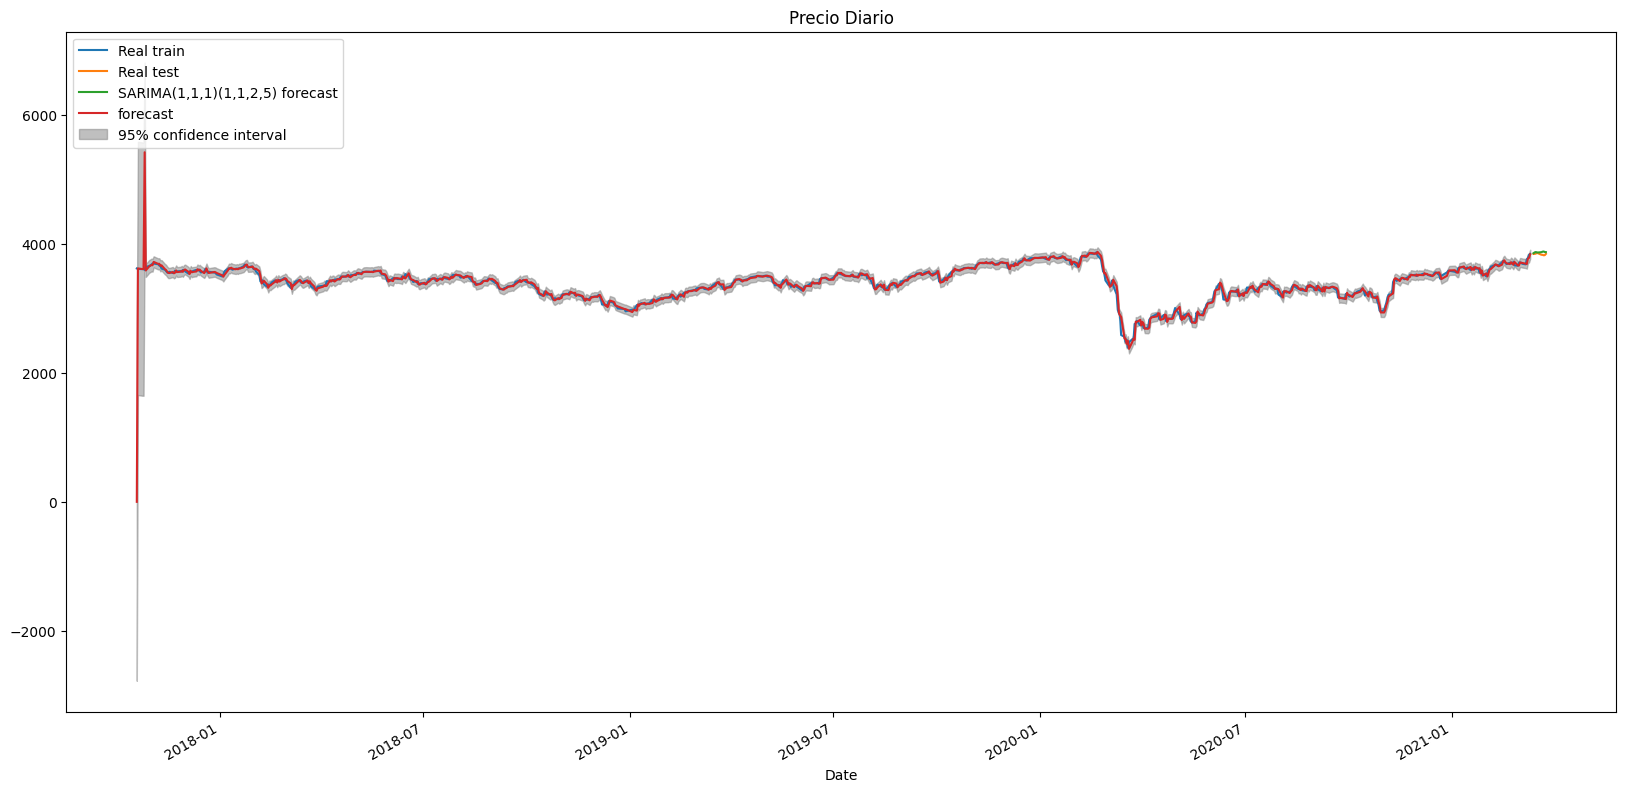

In [34]:
fig, ax = plt.subplots()
ax = wd_train.Open.plot(ax=ax,figsize=(20,10), title = "Precio Diario", label='Real train')
ax = wd_test.Open.plot(ax=ax,figsize=(20,10), title = "Precio Diario", label='Real test')

model_sarima = SARIMAX(wd_train.Open, order=(1,1,1),seasonal_order=(1,1,2,5),enforce_invertibility=False)
results_sarima = model_sarima.fit()
results_sarimafore = results_sarima.forecast(steps=10)
results_sarimafore.index=wd_test.Open.index

ax = results_sarimafore.plot(ax=ax,label='SARIMA(1,1,1)(1,1,2,5) forecast')
plot_predict(results_sarima, dynamic=False,ax=ax)
plt.legend(loc="upper left")
plt.show()

- Vemos que los resultados son bastante satisfactorios, por lo que el modelo SARIMA(0,0,0)(1,1,1,12) es un buen modelo para predecir los valores de la serie. Ahora, vamos a hacer otra prueba visual para ver si el modelo SARIMA(0,0,0)(1,1,1,12) es mejor que el ARIMA(13,1,24). Viendo más de cerca la predicción del modelo.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.03769D+00    |proj g|=  7.31781D-02

At iterate    5    f=  5.03047D+00    |proj g|=  9.14018D-03

At iterate   10    f=  5.01537D+00    |proj g|=  1.07103D-01

At iterate   15    f=  4.95181D+00    |proj g|=  9.10460D-03

At iterate   20    f=  4.95171D+00    |proj g|=  1.37788D-03

At iterate   25    f=  4.95170D+00    |proj g|=  1.77792D-03

At iterate   30    f=  4.95163D+00    |proj g|=  6.50778D-04

At iterate   35    f=  4.95162D+00    |proj g|=  3.40173D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

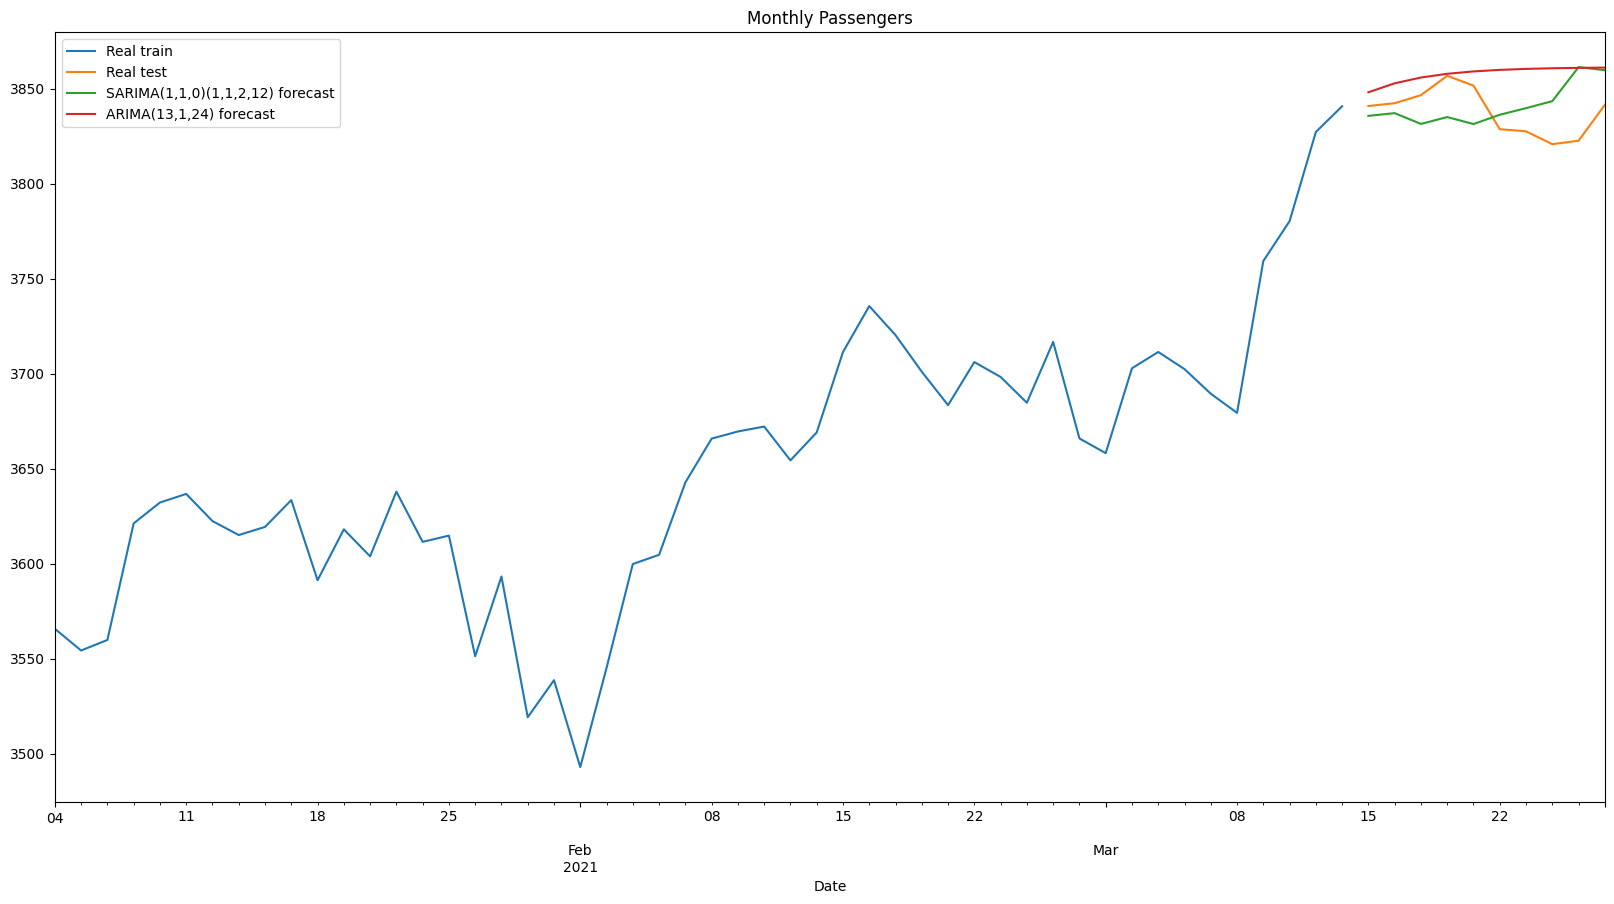

In [35]:
fig, ax = plt.subplots()
ax = wd_train.Open[800:].plot(ax=ax,figsize=(20,10), title = "Monthly Passengers", label='Real train')
ax = wd_test.Open.plot(ax=ax,figsize=(20,10), title = "Monthly Passengers", label='Real test')

model_sarima = SARIMAX(wd_train.Open, order=(1,1,0),seasonal_order=(1,1,2,12),enforce_invertibility=False)
results_sarima = model_sarima.fit()
results_sarimafore = results_sarima.forecast(steps=10)
results_sarimafore.index=wd_test.Open.index

ax = results_sarimafore.plot(ax=ax,label='SARIMA(1,1,0)(1,1,2,12) forecast')
ax = results_arimafore.plot(ax=ax,label='ARIMA(13,1,24) forecast')
plt.legend(loc="upper left")
plt.show()

- A la vista de los resultados, podemos ver que el modelo SARIMA, da mejores resultados que el ARIMA, pues se ajusta mejor a los valores de test y a los que se esperan de la serie.

In [36]:
pip install pmdarima

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [37]:
# auto sarima
# =====================================================================
from pmdarima import auto_arima
auto_arima_model = auto_arima(wd_train.Open, start_p=1, start_q=1,
                              max_p=5, max_q=5, m=5,
                              start_P=0, seasonal=True,
                              d=None, D=1, trace=True,
                              error_action='ignore',  
                              suppress_warnings=True, 
                              stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[5] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,0,0)(0,1,0)[5] intercept   : AIC=10160.305, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[5] intercept   : AIC=8787.637, Time=0.12 sec
 ARIMA(0,0,1)(0,1,1)[5] intercept   : AIC=9518.199, Time=0.11 sec
 ARIMA(0,0,0)(0,1,0)[5]             : AIC=10158.390, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[5] intercept   : AIC=8985.374, Time=0.04 sec
 ARIMA(1,0,0)(2,1,0)[5] intercept   : AIC=8703.214, Time=0.34 sec
 ARIMA(1,0,0)(2,1,1)[5] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(1,0,0)(1,1,1)[5] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,0,0)(2,1,0)[5] intercept   : AIC=10156.197, Time=0.11 sec
 ARIMA(2,0,0)(2,1,0)[5] intercept   : AIC=8678.869, Time=0.36 sec
 ARIMA(2,0,0)(1,1,0)[5] intercept   : AIC=8761.615, Time=0.15 sec
 ARIMA(2,0,0)(2,1,1)[5] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(2,0,0)(1,1,1)[5] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(3,0,0)(2,1,0)[5] intercept   : AIC=8649.865, Tim

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.28835D+00    |proj g|=  5.09452D-01

At iterate    5    f=  5.10814D+00    |proj g|=  8.42928D-03

At iterate   10    f=  5.10229D+00    |proj g|=  2.25169D-02

At iterate   15    f=  5.08452D+00    |proj g|=  2.26918D-02

At iterate   20    f=  5.08011D+00    |proj g|=  1.01473D-02


 This problem is unconstrained.



At iterate   25    f=  5.07968D+00    |proj g|=  1.88440D-03

At iterate   30    f=  5.07806D+00    |proj g|=  1.86964D-02

At iterate   35    f=  5.07733D+00    |proj g|=  3.47528D-03

At iterate   40    f=  5.07726D+00    |proj g|=  1.48547D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42     48      1     0     0   4.508D-06   5.077D+00
  F =   5.0772635911105191     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


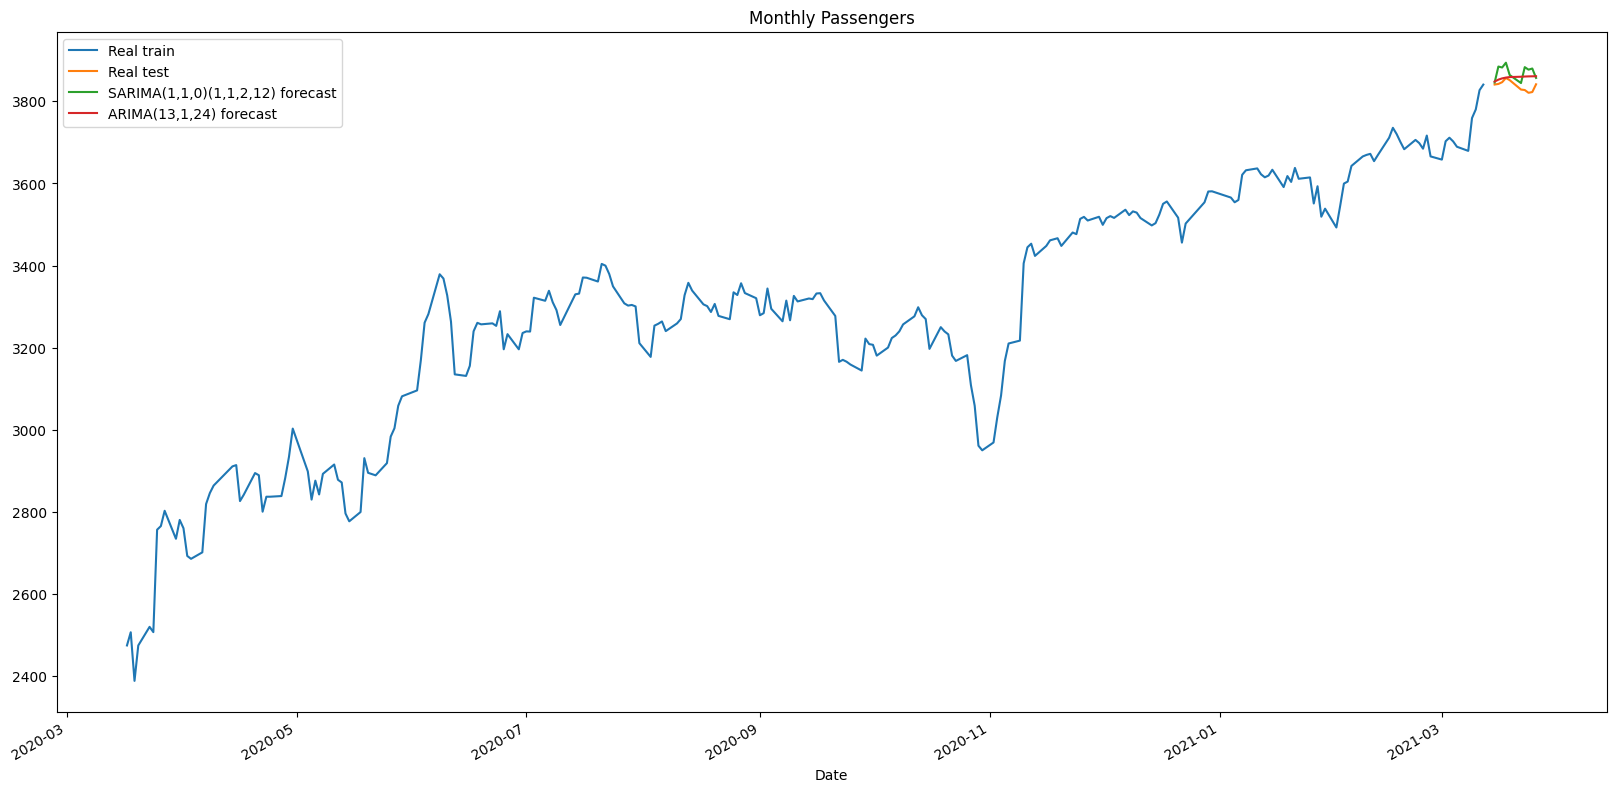

In [38]:
fig, ax = plt.subplots()
ax = wd_train.Open[600:].plot(ax=ax,figsize=(20,10), title = "Monthly Passengers", label='Real train')
ax = wd_test.Open.plot(ax=ax,figsize=(20,10), title = "Monthly Passengers", label='Real test')

model_sarima = SARIMAX(wd_train.Open, order=(3,0,1),seasonal_order=(2,1,0,5),enforce_invertibility=False)
results_sarima = model_sarima.fit()
results_sarimafore = results_sarima.forecast(steps=10)
results_sarimafore.index=wd_test.Open.index

ax = results_sarimafore.plot(ax=ax,label='SARIMA(1,1,0)(1,1,2,12) forecast')
ax = results_arimafore.plot(ax=ax,label='ARIMA(13,1,24) forecast')
plt.legend(loc="upper left")
plt.show()

### 3.3 SARIMAX

Pese a que se dijo en clase que no hicieramos el modelo SARIMAX, al no haber variables exógenas en el dataset, he decidido añadir a mano una variable exógena para poder aplicar el modelo SARIMAX y ver si podemos mejorar los resultados del modelo SARIMA. Dicha variable exógena será los festivos de cada mes, pues es una variable que puede influir en el número de pasajeros de un vuelo en un mes determinado. Tan solo a modo de prueba veamos que pasa.

- Para aplicar esta variable exógena, creamos una nueva columna en el dataframe con los festivos de cada mes y la introducimos en el modelo SARIMAX:

In [39]:
from ydata_profiling import ProfileReport

In [40]:
working_news = news_french[['Date', 'Agency', 'Sentiment Vader TextURL']].copy()
# transformamos la columa de fecha a formato datetime
working_news['Date'] = pd.to_datetime(working_news['Date'], format='%d.%m.%Y')

In [41]:
profile = ProfileReport(working_news, title="Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [71]:
news.Date

38143   2021-02-19
38145   2021-02-19
38146   2021-02-19
38147   2021-02-19
38148   2021-02-19
           ...    
41529   2021-03-19
41530   2021-03-19
41531   2021-03-19
41535   2021-03-19
41540   2021-03-19
Name: Date, Length: 1462, dtype: datetime64[ns]

In [85]:
# dividimos news french por agency 
# =====================================================================
news_agency = working_news.groupby('Agency')

# creamos un dataframe para cada agencia guardado en un diccionario
news_agency_dict = {}
for agency, news in news_agency:
    news_agency_dict[agency] = news

In [86]:
for agency, news in news_agency_dict.items():
    news['target_date'] = pd.NaT  # Initialize with Not-A-Time (NaT)

    # Assuming 'Date' is the index of euro_open DataFrame
    news['target_date'] = news['Date'].map(
        lambda x: x if x in euro_open.index else euro_open[euro_open.index > x].index[0]
    )
    news.reset_index(inplace=True)
    # drop Date column
    news.drop(['Date'], axis=1, inplace=True)
    # rename target_date to Date and set it as index
    news.rename(columns={'target_date': 'Date'}, inplace=True)


In [87]:
# total date range
# =====================================================================
min_date = working_news.Date.min()
max_date = working_news.Date.max()

# get the number of days between the min and max date
num_days = (max_date - min_date).days
num_days

1247

In [88]:
# Agrupar por agencia y contar las fechas únicas
dias_publicacion = working_news.groupby('Agency')['Date'].nunique()

# dias_publicacion ahora contiene el número de días diferentes de publicación para cada agencia
print(dias_publicacion)

Agency
AFP                                       29
AFP Video                                 28
BFG Capital                                1
Banque Richelieu France                    1
Biotech Finances                           3
Boursorama                               151
Boursorama Banque                          7
Boursorama CP                             58
Boursorama avec Media Services            20
Boursorama avec Newsgene                   7
Boursorama avec Pratique.fr                4
Café de la Bourse                          2
DT Expert                                  1
Ecorama                                  748
Edit-Place                                22
Edmond de Rothschild AM                    3
EuroLand Corporate                         1
France 24                                920
Genesta                                    1
GreenSome Finance                          1
H24 Finance pour Boursorama                9
IDIX                                     258
Le 

In [89]:
# we just want those agencies that have published at least 50% of the days, getting the names of the agencies
agencies = dias_publicacion[dias_publicacion > (num_days * 0.5)].index

In [90]:
agencies

Index(['Ecorama', 'France 24', 'Le Point', 'Reuters'], dtype='object', name='Agency')

In [91]:
# for each agency, just group by date and get the mean of the Sentiment Vader TextURL column 
# get the rid of the other columns
# =====================================================================
news_agency_mean_dict = {}
for agency, news in news_agency_dict.items():
    news_agency_mean_dict[agency] = news[['Date', 'Sentiment Vader TextURL']].groupby('Date').mean()

# just get the agencies that we want
news_agency_mean_dict = {agency: news_agency_mean_dict[agency] for agency in agencies}

In [92]:
euro_open

,Open,Returns,Returns_Returns,Ecorama,France 24,Le Point,Reuters
Date,,,,,,,
2017-10-19,3616.489990,NaN,NaN,0.0000,-0.151560,0.189467,-0.102700
2017-10-20,3608.750000,-0.214019,NaN,0.0000,0.419967,0.155625,0.477650
2017-10-23,3606.709961,-0.056530,-73.586343,0.0000,-0.242683,0.295888,0.466760
2017-10-24,3606.639893,-0.001943,-96.563400,0.0000,-0.015720,-0.148546,0.068475
2017-10-25,3609.020020,0.065993,-3496.930104,0.6767,-0.178050,-0.654267,0.495200
...,...,...,...,...,...,...,...
2021-03-22,3828.659912,-0.595860,346.239171,0.0000,0.000000,0.000000,0.000000
2021-03-23,3827.540039,-0.029250,-95.091171,0.0000,0.000000,0.000000,0.000000
2021-03-24,3820.780029,-0.176615,503.817339,0.0000,0.000000,0.000000,0.000000


In [93]:
# add the mean of the each sentiments column to the euro_open dataframe, if the date is not in the news_agency_mean_dict, then the value is 0
# =====================================================================

for agency, news in news_agency_mean_dict.items():
    euro_open[agency] = euro_open.index.map(lambda x: news.loc[x, 'Sentiment Vader TextURL'] if x in news.index else 0)

In [94]:
# train test split
# =====================================================================
size = len(euro_open) - 10
wd_train, wd_test = euro_open.iloc[:size], euro_open.iloc[size:]

In [ ]:
# for each agency we do the sarimax model
# =====================================================================
sarimax_results_dict = {}
for agency, news in news_agency_mean_dict.items():
    model_sarimax = SARIMAX(wd_train.Open,exog=wd_train[agency],order=(3,0,1),seasonal_order=(2,1,0,5),enforce_invertibility=False)
    sarimax_results_dict[agency] = model_sarimax.fit()

In [96]:
# get the best agency
# =====================================================================
best_agency = None
best_aic = None
for agency, results in sarimax_results_dict.items():
    if best_aic is None:
        best_agency = agency
        best_aic = results.aic
    elif results.aic < best_aic:
        best_agency = agency
        best_aic = results.aic

In [97]:
best_agency

'Reuters'

### Predicción de Reuters

In [98]:
sts.adfuller(euro_open[best_agency]) 

(-8.902801298958483,
 1.1590984985073484e-14,
 6,
 853,
 {'1%': -3.438039434877692,
  '5%': -2.8649342774762423,
  '10%': -2.5685773775887872},
 139.29339963035545)

In [99]:
auto_arima_model = auto_arima(wd_train[best_agency], start_p=1, start_q=1,
                              max_p=5, max_q=5, m=5,
                              start_P=0, seasonal=True,
                              d=None, D=1, trace=True,
                              error_action='ignore',  
                              suppress_warnings=True, 
                              stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[5] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,0,0)(0,1,0)[5] intercept   : AIC=707.527, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[5] intercept   : AIC=499.352, Time=0.09 sec
 ARIMA(0,0,1)(0,1,1)[5] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(0,1,0)[5]             : AIC=705.534, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[5] intercept   : AIC=704.986, Time=0.03 sec
 ARIMA(1,0,0)(2,1,0)[5] intercept   : AIC=412.966, Time=0.17 sec
 ARIMA(1,0,0)(2,1,1)[5] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(1,0,0)(1,1,1)[5] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,0,0)(2,1,0)[5] intercept   : AIC=414.886, Time=0.13 sec
 ARIMA(2,0,0)(2,1,0)[5] intercept   : AIC=413.936, Time=0.23 sec
 ARIMA(1,0,1)(2,1,0)[5] intercept   : AIC=414.579, Time=0.28 sec
 ARIMA(0,0,1)(2,1,0)[5] intercept   : AIC=413.257, Time=0.13 sec
 ARIMA(2,0,1)(2,1,0)[5] intercept   : AIC=414.674, Time=0.55 sec
 ARIMA(1,0,0)(2,1,0)[5]             : AIC=410.995, Time=0.10 se

- Hagamos la comparación visual de los modelos SARIMA y SARIMAX para ver cual se ajusta mejor a los valores reales de la serie.

In [100]:
# predict the next 10 days
# =====================================================================
exog_test = SARIMAX(wd_train[best_agency], order=(1,0,0),seasonal_order=(2,1,0,5), enforce_invertibility=False)
exog_results = exog_test.fit()
exog_forecast = exog_results.forecast(steps=10)
exog_forecast.index=wd_test.Open.index

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.63505D-01    |proj g|=  7.95406D-01

At iterate    5    f=  2.37078D-01    |proj g|=  5.81024D-03

At iterate   10    f=  2.37056D-01    |proj g|=  1.27860D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     17      1     0     0   3.169D-05   2.371D-01
  F =  0.23705608664992917     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


In [101]:
exog_forecast

Date
2021-03-15    0.105639
2021-03-16    0.093565
2021-03-17   -0.001903
2021-03-18    0.141508
2021-03-19    0.204241
2021-03-22    0.145191
2021-03-23    0.048065
2021-03-24   -0.030257
2021-03-25    0.119267
2021-03-26    0.183999
Name: predicted_mean, dtype: float64

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.28835D+00    |proj g|=  5.09452D-01

At iterate    5    f=  5.10814D+00    |proj g|=  8.42928D-03

At iterate   10    f=  5.10229D+00    |proj g|=  2.25169D-02

At iterate   15    f=  5.08452D+00    |proj g|=  2.26918D-02

At iterate   20    f=  5.08011D+00    |proj g|=  1.01473D-02


 This problem is unconstrained.



At iterate   25    f=  5.07968D+00    |proj g|=  1.88440D-03

At iterate   30    f=  5.07806D+00    |proj g|=  1.86964D-02

At iterate   35    f=  5.07733D+00    |proj g|=  3.47528D-03

At iterate   40    f=  5.07726D+00    |proj g|=  1.48547D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42     48      1     0     0   4.508D-06   5.077D+00
  F =   5.0772635911105191     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  5.10746D+00    |proj g|=  8.05723D-03

At iterate   10    f=  5.10121D+00    |proj g|=  2.25499D-02

At iterate   15    f=  5.08369D+00    |proj g|=  1.68189D-02

At iterate   20    f=  5.07981D+00    |proj g|=  2.96164D-03

At iterate   25    f=  5.07947D+00    |proj g|=  1.13039D-02

At iterate   30    f=  5.07738D+00    |proj g|=  1.24581D-02

At iterate   35    f=  5.07693D+00    |proj g|=  4.48919D-04

At iterate   40    f=  5.07692D+00    |proj g|=  9.87167D-04

At iterate   45    f=  5.07673D+00    |proj g|=  1.08440D-02

At iterate   50    f=  5.07655D+00    |proj g|=  2.63570D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

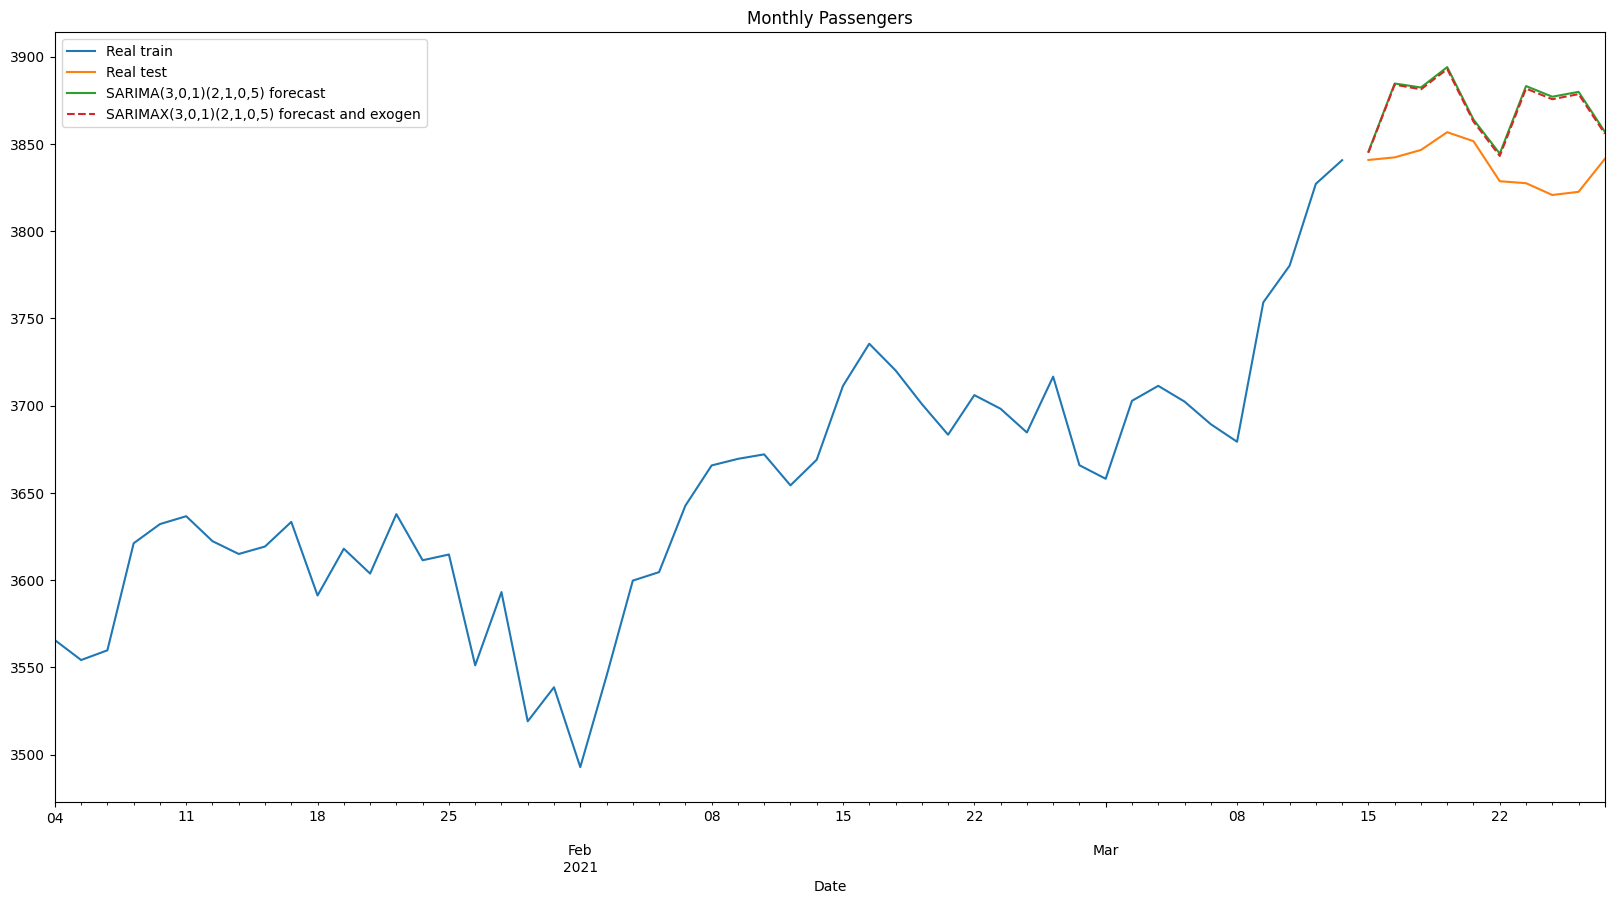

In [102]:
fig, ax = plt.subplots()
ax = wd_train.Open[800:].plot(ax=ax,figsize=(20,10), title = "Monthly Passengers", label='Real train')
ax = wd_test.Open.plot(ax=ax,figsize=(20,10), title = "Monthly Passengers", label='Real test')

model_sarima = SARIMAX(wd_train.Open, order=(3,0,1),seasonal_order=(2,1,0,5), enforce_invertibility=False)
results_sarima = model_sarima.fit()
results_sarimafore = results_sarima.forecast(steps=10)
results_sarimafore.index=wd_test.Open.index

model_sarimax = SARIMAX(wd_train.Open, exog=wd_train[best_agency], order=(3,0,1),seasonal_order=(2,1,0,5), enforce_invertibility=False)
sarimax_results = model_sarimax.fit()
results_sarimaxfore = sarimax_results.forecast(steps=10, exog=exog_forecast)
results_sarimaxfore.index=wd_test.Open.index


ax = results_sarimafore.plot(ax=ax, label='SARIMA(3,0,1)(2,1,0,5) forecast', linestyle='-')
ax = results_sarimaxfore.plot(ax=ax, label='SARIMAX(3,0,1)(2,1,0,5) forecast and exogen', linestyle='--')
plt.legend(loc="upper left")
plt.show()

- Conclusiones:

Tras añadir la variable exógena, vemos que los resultados son bastante satisfactorios, por lo que el modelo SARIMAX(1,1,0)(1,1,2,12) es un buen modelo para predecir los valores de la serie. Sin emabrgo, son prácticamente iguales que los del modelo SARIMA(1,1,0)(1,1,2,12) sin variable exógena. Esto puede deberse a que la variable exógena elegida no influye en la serie o que el modelo SARIMA(1,1,0)(1,1,2,12) ya es un buen modelo para predecir los valores de la serie.

### Análisis de Tópicos de Ruters

Este análisis es para ver si a traves de los tópicos, podemos sacar los más relevantes para mejorar la predicción exógena, ya que hemos visto que con la exógena de la agencia reuter no hemos mejorado casi. Basicamente es para quitar el ruido que pueda proporcionar los topicos no relevantes.

In [116]:
# get only the agency Reuters
# =====================================================================
agency = 'Reuters'
reuters = news_french[news_french['Agency'] == agency]
# reset index and drop the old index
reuters.reset_index(inplace=True)
reuters.drop(['index'], axis=1, inplace=True)
reuters

,Numero news,Numero page,Numero,Date,Heure,Titre,Contenu,Agency,URL,textURL,Nbr image,seconds to 2010,days to 2010,dateDT,Title eng,Content eng,textURL eng,Sentiment Vader Title,Sentiment Vader Text,Sentiment Vader TextURL
0,3,2127,16,19.10.2017,10:59,"En Grande-Bretagne, les ventes au détail subis...",LONDRES (Reuters) - Les ventes au détail en Gr...,Reuters,https://www.boursorama.com/actualite-economiqu...,LONDRES (Reuters) - Les ventes au détail en Gr...,1,246106740.0,2848.457639,2017-10-19 10:59:00,"In Great Britain, retail sales stopped in Sept...",LONDON (Reuters) - Retail sales in Great Brita...,LONDON (Reuters) - Retail sales in Great Brita...,0.4939,0.3182,-0.4019
1,5,2127,14,19.10.2017,11:58,"Dmitri Rybolovlev, président de l'AS Monaco, i...","NICE (Reuters) - Le président de l'AS Monaco, ...",Reuters,https://www.boursorama.com/actualite-economiqu...,"NICE (Reuters) - Le président de l'AS Monaco, ...",1,246110280.0,2848.498611,2017-10-19 11:58:00,"Dmitri Rybolovlev, President of AS Monaco, cha...","NICE (Reuters) - The president of AS Monaco, D...","NICE (Reuters) - The president of AS Monaco, D...",-0.2023,-0.3954,0.9386
2,6,2127,13,19.10.2017,12:25,Amendes et gardes à vue pour les harceleurs de...,PARIS (Reuters) - Les agents de la police de s...,Reuters,https://www.boursorama.com/actualite-economiqu...,PARIS (Reuters) - Les agents de la police de s...,1,246111900.0,2848.517361,2017-10-19 12:25:00,"Fines and custody for street harassers, says C...",PARIS (Reuters) - The daily security police of...,PARIS (Reuters) - The officers of the daily se...,-0.5859,0.4767,0.5719
3,8,2127,11,19.10.2017,14:34,Les eurodéputés proposent d'interdire le glyph...,PARIS (Reuters) - Les députés européens de la ...,Reuters,https://www.boursorama.com/actualite-economiqu...,PARIS (Reuters) - Les députés européens de la ...,1,246119640.0,2848.606944,2017-10-19 14:34:00,MEPs propose banning glyphosate by 2020,PARIS (Reuters) - MEPs in the Committee on the...,PARIS (Reuters) - MEPs in the Committee on the...,0.0000,-0.7841,-0.7264
4,13,2127,6,19.10.2017,19:10,"Hausse de 4,7% des tarifs du courrier en 2018",PARIS (Reuters) - Les tarifs du courrier augme...,Reuters,https://www.boursorama.com/actualite-economiqu...,PARIS (Reuters) - Les tarifs du courrier augme...,1,246136200.0,2848.798611,2017-10-19 19:10:00,4.7% increase in mail rates in 2018,PARIS (Reuters) - Mail rates will increase by ...,The price of the mail will increase by 4.7% on...,0.3182,0.5267,0.8151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12739,41495,4,11,18.03.2021,19:40,"Seize départements, dont Paris, confinés pour ...",PARIS (Reuters) - Le Premier ministre Jean Cas...,Reuters,https://www.boursorama.com/actualite-economiqu...,PARIS (Reuters) - Le Premier ministre Jean Cas...,1,353792400.0,4094.819444,2021-03-18 19:40:00,"Sixteen departments, including Paris, confined...",PARIS (Reuters) - Prime Minister Jean Castex a...,For the last four weeks in the metropolitan ar...,0.0000,0.2263,-0.2960
12740,41513,3,13,18.03.2021,20:59,France: L'impact des restrictions sanitaires e...,PARIS (Reuters) - L'impact sur l'économie fran...,Reuters,https://www.boursorama.com/actualite-economiqu...,PARIS (Reuters) - L'impact sur l'économie fran...,1,353797140.0,4094.874306,2021-03-18 20:59:00,France: The impact of health restrictions is 0...,PARIS (Reuters) - The impact on the French eco...,PARIS (Reuters) - The impact on the French eco...,0.0000,-0.1779,-0.1779
12741,41528,2,16,19.03.2021,07:12,USA/Chine: Première réunion tendue en Alaska,"par Humeyra Pamuk, Michael Martina et David Br...",Reuters,https://www.boursorama.com/actualite-economiqu...,"par Humeyra Pamuk, Michael Martina et David Br...",1,353833920.0,4095.300000,2021-03-19 07:12:00,USA/China: First tense meeting in Alaska,"by Humeyra Pamuk, Michael Martina and David Br...","by Humeyra Pamtuk, Michael Martina and David B...",-0.3400,0.7645,0.6997
12742,41529,2,15,19.03.2021,07:35,Coronavirus:

In [117]:
!pip install --upgrade -q gspread

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [118]:
# list of texts
documents = reuters['Content eng'].tolist()

# bag-of-words
tf_vectorizer = CountVectorizer(
    stop_words='english',
    min_df=2, # minimum number of documents a word must appear in
    max_df=0.25, # maximum number of documents a word can appear in
    lowercase=True,
    max_features=50000,
    token_pattern='[a-zA-Z0-9]{3,}',  
    analyzer = 'word'
)
bag_of_words = tf_vectorizer.fit_transform(documents)
dictionary = tf_vectorizer.get_feature_names_out()
vocabulary = tf_vectorizer.vocabulary_

print("Vocabulary Size: ", len(dictionary))

Vocabulary Size:  14641


Sorted list of terms by frequency:

In [119]:
s = bag_of_words.toarray().sum(axis=0)
st = sorted(range(len(s)), key=lambda k: s[k], reverse=True)
for i,x in enumerate(st[:20]):
  print(dictionary[x],s[x])

said 3654
france 3326
announced 3036
european 2813
coronavirus 2764
french 2722
new 2564
thursday 2462
wednesday 2443
tuesday 2430
minister 2409
friday 2110
monday 2109
president 1992
government 1972
year 1825
according 1702
health 1582
state 1477
published 1385


In [120]:
topics = 5

alpha = 0.1

beta = 0.05 #las palabras respecto a topic

# Run LDA
lda = LatentDirichletAllocation(
    n_components=topics,
    doc_topic_prior=alpha,
    topic_word_prior=beta,
    max_iter=200,
    learning_method='online',
    evaluate_every=1,
    n_jobs = -1,
    random_state=0,
    verbose=1)
lda.fit(bag_of_words)
#si perprejidad que no estabiliza, entonces tenemso que dar más iteraciones


iteration: 1 of max_iter: 200, perplexity: 4107.4648
iteration: 2 of max_iter: 200, perplexity: 3574.8113
iteration: 3 of max_iter: 200, perplexity: 3469.0798
iteration: 4 of max_iter: 200, perplexity: 3426.5421
iteration: 5 of max_iter: 200, perplexity: 3404.0657
iteration: 6 of max_iter: 200, perplexity: 3390.4158
iteration: 7 of max_iter: 200, perplexity: 3381.5181
iteration: 8 of max_iter: 200, perplexity: 3375.3207
iteration: 9 of max_iter: 200, perplexity: 3370.6625
iteration: 10 of max_iter: 200, perplexity: 3367.0710
iteration: 11 of max_iter: 200, perplexity: 3364.1691
iteration: 12 of max_iter: 200, perplexity: 3361.8166
iteration: 13 of max_iter: 200, perplexity: 3359.8528
iteration: 14 of max_iter: 200, perplexity: 3358.2101
iteration: 15 of max_iter: 200, perplexity: 3356.8352
iteration: 16 of max_iter: 200, perplexity: 3355.7122
iteration: 17 of max_iter: 200, perplexity: 3354.7103
iteration: 18 of max_iter: 200, perplexity: 3353.8604
iteration: 19 of max_iter: 200, perpl

LatentDirichletAllocation(doc_topic_prior=0.1, evaluate_every=1,
                          learning_method='online', max_iter=200,
                          n_components=5, n_jobs=-1, random_state=0,
                          topic_word_prior=0.05, verbose=1)

In [126]:
no_top_words = 10
no_top_documents = 2

doc_topics = lda.transform(bag_of_words)
topics = lda.components_

print("LDA Topics")
for topic_idx, topic in enumerate(topics):
    print("-"*30)
    print(" Topic ",(topic_idx)," :")
    print("["," | ".join([dictionary[i]
                    for i in topic.argsort()[:-no_top_words - 1:-1]]),"]")
    top_doc_indices = np.argsort( doc_topics[:,topic_idx] )[::-1][0:no_top_documents]
    for doc_index in top_doc_indices:
        row_index = doc_index +1
        print("[",doc_index,"] (",reuters.iloc[row_index]['Title eng'],") \'",reuters.iloc[row_index]['Content eng'],"\'", [ "{0:.5f}".format(weight) for weight in doc_topics[doc_index]])


LDA Topics
------------------------------
 Topic  0  :
[ minister | president | french | european | emmanuel | macron | said | government | state | france ]
[ 12 ] ( Halliburton exceeds expectations with North America ) ' (Reuters) - In the third quarter, Halliburton posted a profit above expectations, the oil services group having benefited from the increase in North American activity, its main market. The number of drilling wells in the United States, an indicator of future production, now exceeds 700 when it fell in 450 a year ago, the rise in oil prices prompting companies to reinvest ' ['0.99080', '0.00230', '0.00230', '0.00230', '0.00230']
[ 97 ] ( Kevin Spacey erased from a film that was finished ) ' LOS ANGELES (Reuters) - The director and producers of a film whose filming is complete and which is to be released on the screens on December 22 have removed Kevin Spacey from the credits and decided to shoot again all the scenes in which the actor appeared. This completely unusual 

# Topic Evaluation

A model with higher log-likelihood and lower perplexity (exp(-1. * log-likelihood per word)) is considered to be good.

In [128]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda.score(bag_of_words))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda.perplexity(bag_of_words))

# See model parameters
print(lda)

Log Likelihood:  -3531562.78424244
Perplexity:  3344.5381578041565
LatentDirichletAllocation(doc_topic_prior=0.1, evaluate_every=1,
                          learning_method='online', max_iter=200,
                          n_components=5, n_jobs=-1, random_state=0,
                          topic_word_prior=0.05, verbose=1)


Determine the best LDA model:

In [129]:
from sklearn.model_selection import GridSearchCV

# Define Search Param
search_params = {'n_components': [3, 5, 10], 'doc_topic_prior': [.1, .3, .5], 'topic_word_prior': [.01, .03, .05]}

# Init the Model
lda = LatentDirichletAllocation(max_iter=5, learning_method='online', learning_offset=50.,random_state=0)

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(bag_of_words)

# 9 mins de runneo

GridSearchCV(estimator=LatentDirichletAllocation(learning_method='online',
                                                 learning_offset=50.0,
                                                 max_iter=5, random_state=0),
             param_grid={'doc_topic_prior': [0.1, 0.3, 0.5],
                         'n_components': [3, 5, 10],
                         'topic_word_prior': [0.01, 0.03, 0.05]})

Read the best configuration:

In [130]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(bag_of_words))

Best Model's Params:  {'doc_topic_prior': 0.5, 'n_components': 3, 'topic_word_prior': 0.05}
Best Log Likelihood Score:  -772893.0923986874
Model Perplexity:  2974.7442967999636


In [131]:
topics = 3

alpha = 0.5

beta = 0.05 #las palabras respecto a topic

# Run LDA
lda = LatentDirichletAllocation(
    n_components=topics,
    doc_topic_prior=alpha,
    topic_word_prior=beta,
    max_iter=200,
    learning_method='online',
    evaluate_every=1,
    n_jobs = -1,
    random_state=0,
    verbose=1)
lda.fit(bag_of_words)
#si perprejidad que no estabiliza, entonces tenemso que dar más iteraciones

iteration: 1 of max_iter: 200, perplexity: 3575.0112
iteration: 2 of max_iter: 200, perplexity: 3168.3681
iteration: 3 of max_iter: 200, perplexity: 3086.0080
iteration: 4 of max_iter: 200, perplexity: 3052.3373
iteration: 5 of max_iter: 200, perplexity: 3034.4740
iteration: 6 of max_iter: 200, perplexity: 3023.5433
iteration: 7 of max_iter: 200, perplexity: 3016.2788
iteration: 8 of max_iter: 200, perplexity: 3011.1385
iteration: 9 of max_iter: 200, perplexity: 3007.3275
iteration: 10 of max_iter: 200, perplexity: 3004.3966
iteration: 11 of max_iter: 200, perplexity: 3002.0697
iteration: 12 of max_iter: 200, perplexity: 3000.1744
iteration: 13 of max_iter: 200, perplexity: 2998.5995
iteration: 14 of max_iter: 200, perplexity: 2997.2741
iteration: 15 of max_iter: 200, perplexity: 2996.1486
iteration: 16 of max_iter: 200, perplexity: 2995.1831
iteration: 17 of max_iter: 200, perplexity: 2994.3470
iteration: 18 of max_iter: 200, perplexity: 2993.6179
iteration: 19 of max_iter: 200, perpl

LatentDirichletAllocation(doc_topic_prior=0.5, evaluate_every=1,
                          learning_method='online', max_iter=200,
                          n_components=3, n_jobs=-1, random_state=0,
                          topic_word_prior=0.05, verbose=1)

In [132]:
no_top_words = 10
no_top_documents = 2

doc_topics = lda.transform(bag_of_words)
topics = lda.components_

print("LDA Topics")
for topic_idx, topic in enumerate(topics):
    print("-"*30)
    print(" Topic ",(topic_idx)," :")
    print("["," | ".join([dictionary[i]
                    for i in topic.argsort()[:-no_top_words - 1:-1]]),"]")
    top_doc_indices = np.argsort( doc_topics[:,topic_idx] )[::-1][0:no_top_documents]
    for doc_index in top_doc_indices:
        row_index = doc_index +1
        print("[",doc_index,"] (",reuters.iloc[row_index]['Title eng'],") \'",reuters.iloc[row_index]['Content eng'],"\'", [ "{0:.5f}".format(weight) for weight in doc_topics[doc_index]])


LDA Topics
------------------------------
 Topic  0  :
[ minister | said | european | president | french | government | france | emmanuel | macron | state ]
[ 3324 ] ( Europeans: A victory of the RN would be serious for the economy, according to Le Maire ) ' PARIS (Reuters) - A victory of the National Rally (RN, ex-Front national) in the European elections would be detrimental to the French economy and to the single currency, said Bruno Le Maire on Sunday, a week before the election. If nationalisms, through Marine Le Pen, win on 26 May, it will be serious for the situation of our finances, ( ' ['0.97959', '0.01004', '0.01036']
[ 1204 ] ( Stéphane Bern sounds the alarm on the heritage ) ' PARIS (Reuters) - Stéphane Bern, entrusted by the Elysée with a mission on the preservation of the heritage, launched on Saturday a call for a national momentum and warned that he did not exclude leaving this mission at the end of the year if he had the feeling of being just a cache-misere. I arrived 

In [133]:
topicnames = ["topic"+ str(x) for x in range(0, lda.n_components)]
norm_doc_topics = []
for i in doc_topics:
  norm_doc_topics.append([ "{0:.3f}".format(weight) for weight in i])

In [137]:
# add the topics to the dataframe with the other columns
# =====================================================================
reuters['Topic'] = np.argmax(doc_topics, axis=1)
reuters['Topic'] = reuters['Topic'].map(lambda x: topicnames[x])



In [138]:
reuters

,Numero news,Numero page,Numero,Date,Heure,Titre,Contenu,Agency,URL,textURL,...,seconds to 2010,days to 2010,dateDT,Title eng,Content eng,textURL eng,Sentiment Vader Title,Sentiment Vader Text,Sentiment Vader TextURL,Topic
0,3,2127,16,19.10.2017,10:59,"En Grande-Bretagne, les ventes au détail subis...",LONDRES (Reuters) - Les ventes au détail en Gr...,Reuters,https://www.boursorama.com/actualite-economiqu...,LONDRES (Reuters) - Les ventes au détail en Gr...,...,246106740.0,2848.457639,2017-10-19 10:59:00,"In Great Britain, retail sales stopped in Sept...",LONDON (Reuters) - Retail sales in Great Brita...,LONDON (Reuters) - Retail sales in Great Brita...,0.4939,0.3182,-0.4019,topic1
1,5,2127,14,19.10.2017,11:58,"Dmitri Rybolovlev, président de l'AS Monaco, i...","NICE (Reuters) - Le président de l'AS Monaco, ...",Reuters,https://www.boursorama.com/actualite-economiqu...,"NICE (Reuters) - Le président de l'AS Monaco, ...",...,246110280.0,2848.498611,2017-10-19 11:58:00,"Dmitri Rybolovlev, President of AS Monaco, cha...","NICE (Reuters) - The president of AS Monaco, D...","NICE (Reuters) - The president of AS Monaco, D...",-0.2023,-0.3954,0.9386,topic2
2,6,2127,13,19.10.2017,12:25,Amendes et gardes à vue pour les harceleurs de...,PARIS (Reuters) - Les agents de la police de s...,Reuters,https://www.boursorama.com/actualite-economiqu...,PARIS (Reuters) - Les agents de la police de s...,...,246111900.0,2848.517361,2017-10-19 12:25:00,"Fines and custody for street harassers, says C...",PARIS (Reuters) - The daily security police of...,PARIS (Reuters) - The officers of the daily se...,-0.5859,0.4767,0.5719,topic0
3,8,2127,11,19.10.2017,14:34,Les eurodéputés proposent d'interdire le glyph...,PARIS (Reuters) - Les députés européens de la ...,Reuters,https://www.boursorama.com/actualite-economiqu...,PARIS (Reuters) - Les députés européens de la ...,...,246119640.0,2848.606944,2017-10-19 14:34:00,MEPs propose banning glyphosate by 2020,PARIS (Reuters) - MEPs in the Committee on the...,PARIS (Reuters) - MEPs in the Committee on the...,0.0000,-0.7841,-0.7264,topic0
4,13,2127,6,19.10.2017,19:10,"Hausse de 4,7% des tarifs du courrier en 2018",PARIS (Reuters) - Les tarifs du courrier augme...,Reuters,https://www.boursorama.com/actualite-economiqu...,PARIS (Reuters) - Les tarifs du courrier augme...,...,246136200.0,2848.798611,2017-10-19 19:10:00,4.7% increase in mail rates in 2018,PARIS (Reuters) - Mail rates will increase by ...,The price of the mail will increase by 4.7% on...,0.3182,0.5267,0.8151,topic1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12739,41495,4,11,18.03.2021,19:40,"Seize départements, dont Paris, confinés pour ...",PARIS (Reuters) - Le Premier ministre Jean Cas...,Reuters,https://www.boursorama.com/actualite-economiqu...,PARIS (Reuters) - Le Premier ministre Jean Cas...,...,353792400.0,4094.819444,2021-03-18 19:40:00,"Sixteen departments, including Paris, confined...",PARIS (Reuters) - Prime Minister Jean Castex a...,For the last four weeks in the metropolitan ar...,0.0000,0.2263,-0.2960,topic0
12740,41513,3,13,18.03.2021,20:59,France: L'impact des restrictions sanitaires e...,PARIS (Reuters) - L'impact sur l'économie fran...,Reuters,https://www.boursorama.com/actualite-economiqu...,PARIS (Reuters) - L'impact sur l'économie fran...,...,353797140.0,4094.874306,2021-03-18 20:59:00,France: The impact of health restrictions is 0...,PARIS (Reuters) - The impact on the French eco...,PARIS (Reuters) - The impact on the French eco...,0.0000,-0.1779,-0.1779,topic1
12741,41528,2,16,19.03.2021,07:12,USA/Chine: Première réunion tendue en Alaska,"par Humeyra Pamuk, Michael Martina et David Br...",Reuters,https://www.boursorama.com/actualite-economiqu...,"par Humeyra Pamuk, Michael Martina et David Br...",...,353833920.0,4095.300000,2021-03-19 07:12:00,USA/China: First tense meeting in Alaska,"by Humeyra Pamuk, Michael Martina and David Br...","by Humeyra Pamtuk, Michael Martina and David B..."

In [143]:
# group by topic
# =====================================================================
working_reuters = reuters[['Date', 'Topic','Sentiment Vader TextURL']].copy()
# transformamos la columa de fecha a formato datetime
working_reuters['Date'] = pd.to_datetime(working_reuters['Date'], format='%d.%m.%Y')
reuters_topic = working_reuters.groupby('Topic')

In [145]:
# creamos un dataframe para cada agencia guardado en un diccionario
reuters_topic_dict = {}
for topic, news in reuters_topic:
    reuters_topic_dict[topic] = news

for topic, news in reuters_topic_dict.items():
    news['target_date'] = pd.NaT  # Initialize with Not-A-Time (NaT)

    # Assuming 'Date' is the index of euro_open DataFrame
    news['target_date'] = news['Date'].map(
        lambda x: x if x in euro_open.index else euro_open[euro_open.index > x].index[0]
    )
    news.reset_index(inplace=True)
    # drop Date column
    news.drop(['Date'], axis=1, inplace=True)
    # rename target_date to Date and set it as index
    news.rename(columns={'target_date': 'Date'}, inplace=True)

In [146]:
reuters_topic_mean_dict = {}
for topic, news in reuters_topic_dict.items():
    reuters_topic_mean_dict[topic] = news[['Date', 'Sentiment Vader TextURL']].groupby('Date').mean()

for topic, news in reuters_topic_mean_dict.items():
    euro_open[topic] = euro_open.index.map(lambda x: news.loc[x, 'Sentiment Vader TextURL'] if x in news.index else 0)

In [147]:
euro_open

,Open,Returns,Returns_Returns,Ecorama,France 24,Le Point,Reuters,topic0,topic1,topic2
Date,,,,,,,,,,
2017-10-19,3616.489990,NaN,NaN,0.0000,-0.151560,0.189467,-0.102700,-0.077250,0.206600,-0.325867
2017-10-20,3608.750000,-0.214019,NaN,0.0000,0.419967,0.155625,0.477650,0.477650,0.000000,0.000000
2017-10-23,3606.709961,-0.056530,-73.586343,0.0000,-0.242683,0.227411,0.400214,0.487667,0.334625,0.000000
2017-10-24,3606.639893,-0.001943,-96.563400,0.0000,-0.015720,-0.148546,0.068475,0.381217,0.127750,-0.988300
2017-10-25,3609.020020,0.065993,-3496.930104,0.6767,-0.178050,-0.654267,0.495200,0.802000,0.418500,0.000000
...,...,...,...,...,...,...,...,...,...,...
2021-03-22,3828.659912,-0.595860,346.239171,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-03-23,3827.540039,-0.029250,-95.091171,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-03-24,3820.780029,-0.176615,503.817339,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
# train test split
# =====================================================================
size = len(euro_open) - 10
wd_train, wd_test = euro_open.iloc[:size], euro_open.iloc[size:]
# for each agency we do the sarimax model
# =====================================================================
sarimax_results_dict = {}

for topic, news in reuters_topic_mean_dict.items():
    model_sarimax = SARIMAX(wd_train.Open,exog=wd_train[topic],order=(3,0,1),seasonal_order=(2,1,0,5),enforce_invertibility=False)
    sarimax_results_dict[topic] = model_sarimax.fit()

In [150]:
# get the best topic
# =====================================================================
best_topic = None
best_aic = None
for topic, results in sarimax_results_dict.items():
    if best_aic is None:
        best_topic = topic
        best_aic = results.aic
    elif results.aic < best_aic:
        best_topic = topic
        best_aic = results.aic

best_topic

'topic1'

### Predicción del topico 1

In [151]:
sts.adfuller(euro_open[best_topic])

(-4.242796620916119,
 0.0005572067146326751,
 15,
 844,
 {'1%': -3.4381216826257956,
  '5%': -2.8649705364894635,
  '10%': -2.568596692178972},
 855.787423079785)

In [153]:
auto_arima_model = auto_arima(wd_train[best_topic], start_p=1, start_q=1,
                                max_p=5, max_q=5, m=5,
                                start_P=0, seasonal=True,
                                d=None, D=1, trace=True,
                                error_action='ignore',  
                                suppress_warnings=True, 
                                stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[5] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,0,0)(0,1,0)[5] intercept   : AIC=1413.668, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[5] intercept   : AIC=1221.730, Time=0.11 sec
 ARIMA(0,0,1)(0,1,1)[5] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,0,0)(0,1,0)[5]             : AIC=1411.668, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[5] intercept   : AIC=1415.341, Time=0.02 sec
 ARIMA(1,0,0)(2,1,0)[5] intercept   : AIC=1073.294, Time=0.13 sec
 ARIMA(1,0,0)(2,1,1)[5] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(1,0,0)(1,1,1)[5] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,0,0)(2,1,0)[5] intercept   : AIC=1074.983, Time=0.13 sec
 ARIMA(2,0,0)(2,1,0)[5] intercept   : AIC=1073.816, Time=0.30 sec
 ARIMA(1,0,1)(2,1,0)[5] intercept   : AIC=1059.722, Time=0.46 sec
 ARIMA(1,0,1)(1,1,0)[5] intercept   : AIC=1222.326, Time=0.26 sec
 ARIMA(1,0,1)(2,1,1)[5] intercept   : AIC=inf, Time=0.81 sec
 ARIMA(1,0,1)(1,1,1)[5] intercept   : AIC=inf, Time=0.50 s

In [154]:
# predict the next 10 days
# =====================================================================
exog_test = SARIMAX(wd_train[best_topic], order=(1,0,0),seasonal_order=(2,1,0,5), enforce_invertibility=False)
exog_results = exog_test.fit()
exog_forecast = exog_results.forecast(steps=10)
exog_forecast.index=wd_test.Open.index

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.63155D-01    |proj g|=  6.00453D-01

At iterate    5    f=  6.25470D-01    |proj g|=  3.45558D-03

At iterate   10    f=  6.25467D-01    |proj g|=  2.14578D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     13      1     0     0   1.329D-05   6.255D-01
  F =  0.62546707407376123     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


In [155]:
exog_forecast

Date
2021-03-15    0.243591
2021-03-16    0.142182
2021-03-17    0.320056
2021-03-18    0.201097
2021-03-19    0.592028
2021-03-22    0.364939
2021-03-23   -0.103510
2021-03-24    0.329316
2021-03-25    0.252410
2021-03-26    0.508899
Name: predicted_mean, dtype: float64

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.28835D+00    |proj g|=  5.09452D-01

At iterate    5    f=  5.10814D+00    |proj g|=  8.42928D-03

At iterate   10    f=  5.10229D+00    |proj g|=  2.25169D-02

At iterate   15    f=  5.08452D+00    |proj g|=  2.26918D-02

At iterate   20    f=  5.08011D+00    |proj g|=  1.01473D-02


 This problem is unconstrained.



At iterate   25    f=  5.07968D+00    |proj g|=  1.88440D-03

At iterate   30    f=  5.07806D+00    |proj g|=  1.86964D-02

At iterate   35    f=  5.07733D+00    |proj g|=  3.47528D-03

At iterate   40    f=  5.07726D+00    |proj g|=  1.48547D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42     48      1     0     0   4.508D-06   5.077D+00
  F =   5.0772635911105191     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   15    f=  5.08595D+00    |proj g|=  1.62412D-02

At iterate   20    f=  5.08126D+00    |proj g|=  4.86339D-03

At iterate   25    f=  5.08088D+00    |proj g|=  4.43627D-03

At iterate   30    f=  5.07885D+00    |proj g|=  2.43890D-02

At iterate   35    f=  5.07760D+00    |proj g|=  5.49771D-03

At iterate   40    f=  5.07747D+00    |proj g|=  1.04011D-03

At iterate   45    f=  5.07743D+00    |proj g|=  1.70333D-03

At iterate   50    f=  5.07676D+00    |proj g|=  6.88823D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     62      1     0     0   6.888D-03   5.077D+00
  F =   5.07676017902

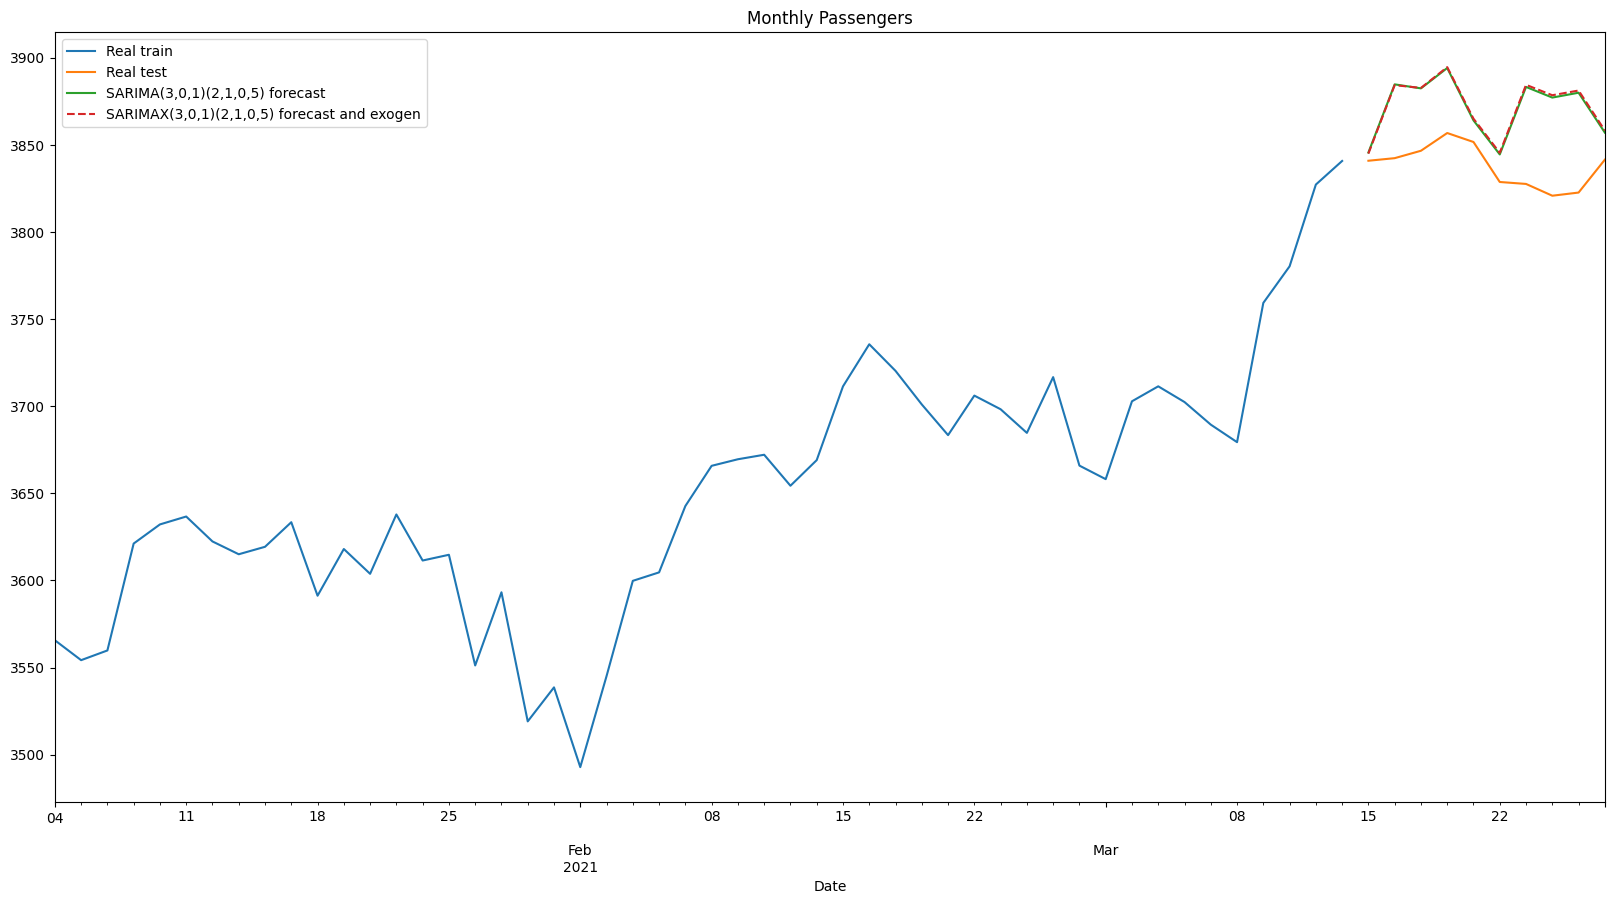

In [157]:
fig, ax = plt.subplots()
ax = wd_train.Open[800:].plot(ax=ax,figsize=(20,10), title = "Monthly Passengers", label='Real train')
ax = wd_test.Open.plot(ax=ax,figsize=(20,10), title = "Monthly Passengers", label='Real test')

model_sarima = SARIMAX(wd_train.Open, order=(3,0,1),seasonal_order=(2,1,0,5), enforce_invertibility=False)
results_sarima = model_sarima.fit()
results_sarimafore = results_sarima.forecast(steps=10)
results_sarimafore.index=wd_test.Open.index

model_sarimax = SARIMAX(wd_train.Open, exog=wd_train[best_topic], order=(3,0,1),seasonal_order=(2,1,0,5), enforce_invertibility=False)
sarimax_results = model_sarimax.fit()
results_sarimaxfore = sarimax_results.forecast(steps=10, exog=exog_forecast)
results_sarimaxfore.index=wd_test.Open.index


ax = results_sarimafore.plot(ax=ax, label='SARIMA(3,0,1)(2,1,0,5) forecast', linestyle='-')
ax = results_sarimaxfore.plot(ax=ax, label='SARIMAX(3,0,1)(2,1,0,5) forecast and exogen', linestyle='--')
plt.legend(loc="upper left")
plt.show()
